In [1]:
import numpy as np
import pandas as pd
import torch
import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from scipy.optimize import linprog
import requests
from typing import List, Dict, Tuple, Optional
import networkx as nx
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates

/opt/homebrew/Caskroom/miniconda/base/envs/buggy/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#  run once to download the old lmarena dataset in your local directory
########################################################
# url = "https://storage.googleapis.com/arena_external_data/public/clean_battle_20240814_public.json"
# response = requests.get(url)
# with open('lmarena_20240814.json', 'wb') as file:
#     file.write(response.content)
# file.close()
########################################################

In [3]:
USE_NEW_DATASET = True # set to True to use the new lmarena dataset, False to use the old one

print("Loading dataset...")
if USE_NEW_DATASET:
    dataset = load_dataset("lmarena-ai/arena-human-preference-140k", split="train")
    df = dataset.to_pandas()
    columns_to_keep = ['model_a', 'model_b', 'winner', 'language', 'timestamp', 'is_code', 'category_tag']
    df = df[columns_to_keep]
else:
    with open('lmarena_20240814.json', 'r') as file:
        df = pd.read_json(file)
    # we use anony battles only for leaderboard and de-duplicate top 0.1% redudant prompts 
    # as suggested by lmarena https://lmsys.org/blog/2024-05-17-category-hard/#note-enhancing-quality-through-de-duplication
    df = df[df["anony"] == True]
    print(f"Number of votes before dedup: {len(df):,}")
    df = df[df["dedup_tag"].apply(lambda x: x.get("sampled", False))]


    columns_to_keep = ['model_a', 'model_b', 'winner', 'language', 'tstamp', 'is_code', 'is_refusal', 'category_tag']
    df = df[columns_to_keep]

    df = df.sort_values(by=["tstamp"], ascending=True)
    df["timestamp"] = pd.to_datetime(df["tstamp"], unit="s") # to be consistent with new dataset
    df = df.drop(columns=["tstamp"])

all_models = sorted(set(df["model_a"]) | set(df["model_b"]))
m = len(all_models)
print(f"Number of votes and models: {len(df):,} votes, {m} models")

Loading dataset...
Number of votes and models: 135,634 votes, 53 models


In [4]:
# option 1: divide votes based on prompt categories

# def infer_category(category_tag, is_code):
#     # we need to handle both old and new format of category_tag
#     # check for creative writing, math, instruction following, coding
#     categories = []
#     cw = category_tag.get("creative_writing_v0.1", {})
#     if bool(cw.get("creative_writing", False)) or str(cw.get("score", "")).lower() in {"yes", "true", "1"}:
#         categories.append("creative")
#     criteria = category_tag.get("criteria_v0.1", {})
#     if bool(criteria.get("creativity", False)):
#           categories.append("creative")
#     if bool(category_tag.get("math_v0.1", {}).get("math", False)):
#         categories.append("math")
#     if bool(category_tag.get("if_v0.1", {}).get("if", False)):
#         categories.append("if")
#     if not (isinstance(is_code, float) and pd.isna(is_code)) and bool(is_code):
#         categories.append("coding")
    
#     return categories if categories else ["other"]

# df["category"] = [infer_category(tag, code) for tag, code in zip(df.get("category_tag", pd.Series([None] * len(df))), df.get("is_code", pd.Series([False] * len(df))))]

# option 2: divide votes based on language
TOP_N_LANGUAGES = 4

def get_language_name(code):
    language_map = {'en': 'English', 'pl': 'Polish', 'und': 'Unknown', 'ru': 'Russian', 'de': 'German', 'fr': 'French', 'es': 'Spanish', 'it': 'Italian', 'zh': 'Chinese', 'ja': 'Japanese', 'pt': 'Portuguese', 'ar': 'Arabic', 'ko': 'Korean', 'nl': 'Dutch', 'tr': 'Turkish', 'vi': 'Vietnamese', 'hi': 'Hindi', 'th': 'Thai', 'id': 'Indonesian', 'uk': 'Ukrainian', 'unknown': 'Unknown'}
    return language_map.get(code, code.capitalize())

df = df[df["language"].notna()].reset_index(drop=True)
df = df[~df["language"].isin(["unknown", "und"])].reset_index(drop=True)

language_counts = df["language"].value_counts()
top_languages = language_counts.head(TOP_N_LANGUAGES).index.tolist()
top_language_names = [get_language_name(lang) for lang in top_languages]
print(f"\nTop {TOP_N_LANGUAGES} languages selected: {top_language_names}")
df = df[df["language"].isin(top_languages)].reset_index(drop=True)
df["category"] = df["language"].apply(lambda x: [get_language_name(x)])


Top 4 languages selected: ['English', 'Polish', 'Russian', 'Chinese']


In [5]:
# keep only rows with a unique category 

if df["category"].dtype == 'object' and isinstance(df["category"].iloc[0], str):
    df["category"] = df["category"].apply(lambda x: [x] if isinstance(x, str) else x)

print("Before removing multi-category rows:")
print("="*60)
combinations = df["category"].apply(lambda x: tuple(sorted(x)) if isinstance(x, list) else (x,)).value_counts().sort_values(ascending=False)
for combo, count in combinations.items():
    cat_name = ', '.join(combo) if len(combo) > 1 else combo[0]
    print(f"  {cat_name:15s}: {count:>8,} rows")

df = df[df["category"].apply(lambda x: len(x) if isinstance(x, list) else 1) == 1].reset_index(drop=True)
df["category"] = df["category"].apply(lambda x: x[0] if isinstance(x, list) else x)  # Flatten single-element lists

print("After removing multi-category rows:")
print("="*60)
category_counts = df["category"].value_counts().sort_values(ascending=False)
for cat, count in category_counts.items():
    print(f"  {cat:15s}: {count:>8,} rows")

print(f"\nTotal rows: {len(df):,}")

Before removing multi-category rows:
  English        :   71,175 rows
  Polish         :   13,813 rows
  Russian        :    9,263 rows
  Chinese        :    6,501 rows
After removing multi-category rows:
  English        :   71,175 rows
  Polish         :   13,813 rows
  Russian        :    9,263 rows
  Chinese        :    6,501 rows

Total rows: 100,752


In [6]:
df["timestamp"] = pd.to_datetime(df["timestamp"], errors="coerce")
df["week"] = df["timestamp"].dt.to_period("W").dt.start_time
df["category"] = df["category"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else str(x))

weekly_counts = df.groupby(["week", "category"]).size().unstack(fill_value=0).sort_index()

sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams.update({
    "font.size": 11,
    "axes.labelsize": 12,
    "axes.titlesize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "pdf.fonttype": 42,
    "ps.fonttype": 42,
    "font.family": "sans-serif",
    "axes.linewidth": 0.8,
    "grid.linewidth": 0.5,
    "xtick.major.width": 0.6,
    "ytick.major.width": 0.6,
})

def _slugify(s):
    s = str(s).lower()
    s = re.sub(r'[^a-z0-9]+', '_', s).strip('_')
    return s + ".pdf"

def plot_category_distribution(proportions_df, title, exclude_other=False, out_pdf=None, top_k=None):
    d = proportions_df.copy()
    if exclude_other and "other" in d.columns:
        d = d.drop(columns=["other"], errors="ignore")
    d = d.replace([np.inf, -np.inf], np.nan).fillna(0.0)
    d = d.loc[d.sum(axis=1) > 0]
    if d.empty:
        return

    if top_k is not None and top_k > 0 and d.shape[1] > top_k:
        total = d.sum(axis=0).sort_values(ascending=False)
        keep = total.index[:top_k].tolist()
        d = d[keep]

    cols = d.columns.tolist()
    palette = sns.color_palette("husl", n_colors=len(cols))
    color_map = dict(zip(cols, palette))

    fig, ax = plt.subplots(figsize=(9, 4.8))

    x = pd.to_datetime(d.index)
    for c in cols:
        y = d[c].to_numpy(float) * 100
        ax.plot(x, y, marker="o", linewidth=1.3, markersize=4.5, label=c, color=color_map[c], alpha=0.9)

    # ax.set_title(title, pad=10)
    ax.set_xlabel("Week", labelpad=6)
    ax.set_ylabel("Mixture distribution in votes collected per week (%)", labelpad=6)
    # ax.set_ylabel("Mixture distribution in votes up to current week (%)", labelpad=6)

    ax.grid(True, alpha=0.25, linestyle="-", linewidth=0.4)
    ax.set_axisbelow(True)

    # ax.xaxis.set_major_locator(mdates.AutoDateLocator(minticks=5, maxticks=10))
    # ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
    ax.tick_params(axis="x", rotation=0)

    # leg = ax.legend(
    #     frameon=True, loc="center left", bbox_to_anchor=(1.02, 0.5),
    #     framealpha=0.95, facecolor="white", edgecolor="lightgray",
    #     borderpad=0.8, labelspacing=0.6, title="Category"
    # )
    # leg.get_title().set_fontsize(10)

    fig.tight_layout()
    if out_pdf is None:
        out_pdf = _slugify(title)
    fig.savefig(out_pdf, bbox_inches="tight", dpi=300)
    plt.close(fig)
    print("saved:", out_pdf)

weekly_proportions_all = weekly_counts.div(weekly_counts.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
weekly_counts_no_other = weekly_counts.drop(columns=["other"], errors="ignore")
weekly_proportions_no_other = weekly_counts_no_other.div(weekly_counts_no_other.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

cumulative_counts_all = weekly_counts.cumsum()
cumulative_proportions_all = cumulative_counts_all.div(cumulative_counts_all.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)
cumulative_counts_no_other = weekly_counts_no_other.cumsum()
cumulative_proportions_no_other = cumulative_counts_no_other.div(cumulative_counts_no_other.sum(axis=1).replace(0, np.nan), axis=0).fillna(0.0)

plot_category_distribution(weekly_proportions_no_other, "Distribution of Vote Categories Collected Per Week", exclude_other=True)
plot_category_distribution(cumulative_proportions_no_other, "Cumulative Distribution of Vote Categories", exclude_other=True)

print(f"Week range: {df['week'].min()} to {df['week'].max()}")
print(f"Total weeks: {len(weekly_proportions_all)}")


saved: distribution_of_vote_categories_collected_per_week.pdf
saved: cumulative_distribution_of_vote_categories.pdf
Week range: 2025-04-14 00:00:00 to 2025-07-21 00:00:00
Total weeks: 15


In [7]:
def simplify_model_name(full_name: str) -> str:
    name = full_name.lower()
    patterns = [
        ("claude-opus-4-20250514-thinking-16k", "Opus 4 (T)"),
        ("claude-opus-4-20250514", "Opus 4"),
        ("claude-sonnet-4-20250514-thinking-32k", "Sonnet 4 (T)"),
        ("claude-sonnet-4-20250514", "Sonnet 4"),
        ("claude-3-7-sonnet-20250219-thinking-32k", "Sonnet 3.7 (T)"),
        ("claude-3-7-sonnet-20250219", "Sonnet 3.7"),
        ("claude-3-5-sonnet-20241022", "Sonnet 3.5 v2"),
        ("claude-3-5-haiku-20241022", "Haiku 3.5"),
        ("claude-3-5-sonnet-20240620", "Sonnet 3.5 v1"),
        ("claude-3-opus-20240229", "Opus 3"),
        ("claude-3-sonnet-20240229", "Sonnet 3"),
        ("claude-3-haiku-20240307", "Haiku 3"),

        ("gpt-4.1-mini-2025-04-14", "GPT-4.1 Mini"),
        ("gpt-4.1-2025-04-14", "GPT-4.1"),
        ("chatgpt-4o-latest-20250326", "GPT-4o v3"),
        ("gpt-4o-2024-11-20", "GPT-4o v2"),
        ("gpt-4o-2024-05-13", "GPT-4o v1"),
        ("gpt-4o-mini-2024-07-18", "GPT-4o Mini"),
        ("gpt-3.5-turbo-0125", "GPT-3.5 Turbo"),
        ("gpt-4-0125-preview", "GPT-4 v3"),
        ("gpt-4-1106-preview", "GPT-4 v2"),
        ("gpt-4-0613", "GPT-4 v1"),
        ("gpt-4-turbo-2024-04-09", "GPT-4 Turbo"),
        
        ("amazon.nova-pro-v1:0", "Nova Pro"),
        ("amazon-nova-experimental-chat-05-14", "Nova Exp"),
        
        ("o4-mini-2025-04-16", "o4 Mini"),
        ("o3-mini", "o3 Mini"),
        ("o3-2025-04-16", "o3"),
        
        ("gemini-2.5-pro-preview-05-06", "Gemini 2.5 Pro Preview v2"),
        ("gemini-2.5-pro-preview-03-25", "Gemini 2.5 Pro Preview v1"),
        ("gemini-2.5-pro", "Gemini 2.5 Pro"),
        ("gemini-2.5-flash-lite-preview-06-17-thinking", "Gemini 2.5 Flash Lite (T)"),
        ("gemini-2.5-flash-preview-04-17", "Gemini 2.5 Flash Preview"),
        ("gemini-2.5-flash", "Gemini 2.5 Flash"),
        ("gemini-2.0-flash-thinking-exp-01-21", "Gemini 2.0 Flash Exp (T)"),
        ("gemini-2.0-flash-001", "Gemini 2.0 Flash"),
        ("gemini-1.5-flash-api-0514", "Gemini 1.5 Flash"),
        ("gemini-1.5-pro-api-0514", "Gemini 1.5 Pro v2"),
        ("gemini-1.5-pro-exp-0801", "Gemini 1.5 Pro v1"),
        ("gemini-advanced-0514", "Gemini Advanced"),
        
        ("gemma-3n-e4b-it", "Gemma 3N"),
        ("gemma-3-27b-it", "Gemma 3"),
        ("gemma-2-27b-it", "Gemma 2 27B"),
        ("gemma-2-9b-it", "Gemma 2 9B"),
        ("gemma-2-2b-it", "Gemma 2 2B"),
        
        ("deepseek-r1-0528", "DeepSeek R1"),
        ("deepseek-v3-0324", "DeepSeek V3"),
        ("deepseek-coder-v2", "DeepSeek Coder V2"),
        ("deepseek-v2-api-0628", "DeepSeek V2"),

        ("phi-3-medium-4k-instruct", "Phi-3 Medium"),
        ("phi-3-mini-4k-instruct-june-2024", "Phi-3 Mini"),

        
        ("grok-4-0709", "Grok-4"),
        ("grok-3-mini-beta", "Grok-3 Mini Beta"),
        ("grok-3-mini-high", "Grok-3 Mini High"),
        ("grok-3-preview-02-24", "Grok-3 Preview"),
        
        ("llama-4-scout-17b-16e-instruct", "Llama 4 Scout"),
        ("llama-4-maverick-17b-128e-instruct", "Llama 4 Maverick"),
        ("llama-4-maverick-03-26-experimental", "Llama 4 Maverick Exp"),
        ("llama-3.3-70b-instruct", "Llama 3.3 70B"),

        ("llama-3.1-405b-instruct", "Llama 3.1 405B"),
        ("llama-3.1-70b-instruct", "Llama 3.1 70B"),
        ("llama-3.1-8b-instruct", "Llama 3.1 8B"),
        ("llama-3-70b-instruct", "Llama 3 70B"),
        ("llama-3-8b-instruct", "Llama 3 8B"),
        
        ("mistral-medium-2505", "Mistral Medium"),
        ("mistral-small-3.1-24b-instruct-2503", "Mistral Small v2"),
        ("mistral-small-2506", "Mistral Small v1"),
        ("mistral-large-2402", "Mistral Large v1"),
        ("mistral-large-2407", "Mistral Large v2"),
        ("mixtral-8x22b-instruct-v0.1", "Mixtral 8×22B"),
        ("mixtral-8x7b-instruct-v0.1", "Mixtral 8×7B"),
        ("magistral-medium-2506", "Magistral Medium"),
        
        ("qwen3-235b-a22b-instruct-2507", "Qwen3 235B v2 (T)"),
        ("qwen3-235b-a22b-no-thinking", "Qwen3 235B"),
        ("qwen3-235b-a22b", "Qwen3 235B v1 (T)"),
        ("qwen3-30b-a3b", "Qwen3 30B"),
        ("qwen-max-2025-01-25", "Qwen Max"),
        ("qwq-32b", "QWQ-32B"),
        ("qwen2-72b-instruct", "Qwen2 72B"),
        
        ("command-a-03-2025", "Command A"),
        ("command-r-plus", "Command R+"),
        ("command-r", "Command R"),

        ("kimi-k2-0711-preview", "Kimi K2"),
        ("minimax-m1", "Minimax M1"),
        ("hunyuan-turbos-20250416", "Hunyuan"),
        ("reka-core-20240501", "Reka Core"),
        ("reka-flash-preview-20240611", "Reka Flash Preview"),
        ("reka-flash-20240722", "Reka Flash"),
        ("yi-large-preview", "Yi Large Preview"),
        ("yi-large", "Yi Large"),
        ("athene-70b-0725", "Athene 70B"),
    ]
    
    for pattern, display_name in patterns:
        if pattern in name: return display_name
    return full_name


PRICES = {
    "amazon-nova-experimental-chat-05-14": 1.2, 
    "amazon.nova-pro-v1:0": 0.80,
    "chatgpt-4o-latest-20250326": 2.50, #acc to latest gpt-4o pricing
    "claude-3-5-haiku-20241022": 0.80, # anthropic pricing
     "claude-3-5-sonnet-20241022": 3.00, # anthropic pricing
    "claude-3-7-sonnet-20250219": 3.00, # anthropic pricing
    "claude-3-7-sonnet-20250219-thinking-32k": 3.00, # anthropic pricing
    "claude-opus-4-20250514": 15.00,  # anthropic pricing
    "claude-opus-4-20250514-thinking-16k": 15.00, # anthropic pricing
    "claude-sonnet-4-20250514": 3.00, # anthropic pricing
    "claude-sonnet-4-20250514-thinking-32k": 3.00, # anthropic pricing
    "command-a-03-2025": 2.5, #couldnt find on official cohere website but a bunch of sources say 2.5
    "deepseek-r1-0528": 0.28, # cache miss price, deepseek website
    "deepseek-v3-0324": 0.28, # cache miss price, deepseek website
    "gemini-2.0-flash-001": 0.10, # google pricing
    "gemini-2.5-flash": 0.30, # google pricing
    "gemini-2.0-flash-thinking-exp-01-21": 0.30, # google pricing
    "gemini-2.5-flash-lite-preview-06-17-thinking": 0.10, # google pricing
    "gemini-2.5-flash-preview-04-17": 0.30, # google pricing
     "gemini-2.5-pro": 1.25, # google pricing
    "gemini-2.5-pro-preview-03-25": 1.25,  # google pricing
    "gemini-2.5-pro-preview-05-06": 1.25, # google pricing
    "gemma-3-27b-it": 0.23, # aws bedrock pricing
    "gemma-3n-e4b-it": 0.04,
    "gpt-4.1-2025-04-14": 2.00, #openai pricing
     "gpt-4.1-mini-2025-04-14": 0.40, #openai pricing
    "gpt-4o-mini-2024-07-18": 0.15, 
    "gpt-4o-2024-11-20": 2.50,
    "grok-3-mini-beta": 0.30, 
    "grok-3-mini-high": 0.30,
     "grok-3-preview-02-24": 1.00,
    "grok-4-0709": 3.00,
     "hunyuan-turbos-20250416": 0.5,
    "kimi-k2-0711-preview": 0.60,
    "llama-3.3-70b-instruct": 0.6, 
    "llama-4-maverick-03-26-experimental": 0.24, # aws bedrock pricing
    "llama-4-maverick-17b-128e-instruct": 0.24, # aws bedrock pricing
    "llama-4-scout-17b-16e-instruct": 0.4,
    "magistral-medium-2506": 2.0, 
    "minimax-m1": 0.30,
    "mistral-medium-2505": 0.4, #mistral pricing
     "mistral-small-2506": 1.0,
    "mistral-small-3.1-24b-instruct-2503": 1.0,
    "o3-2025-04-16": 2.00, #openai pricing
     "o3-mini": 1.10, #openai pricing
      "o4-mini-2025-04-16": 1.10, #openai pricing
    "qwen-max-2025-01-25": 1.0, 
    "qwen3-235b-a22b": 0.53,
    "qwen3-235b-a22b-no-thinking": 0.22, #aws bedrock pricing
    "qwen3-30b-a3b": 0.15, #aws bedrock pricing
    "qwq-32b": 0.4, 
    "qwen3-235b-a22b-instruct-2507": 0.53,
    
    "gpt-3.5-turbo-0125": 0.5,
    "gpt-4-0125-preview": 10.0,
    "gpt-4-0613": 30.0,
    "gpt-4-1106-preview": 10.0,
    "gpt-4-turbo-2024-04-09": 10.0,
    "gpt-4o-2024-05-13": 5.0,
    "gpt-4o-mini-2024-07-18": 0.15,

    "command-r": 0.15,
    "command-r-plus": 2.5,

    "claude-3-5-sonnet-20240620": 6.0,
    "claude-3-haiku-20240307": 0.25,
    "claude-3-opus-20240229": 15.0,
    "claude-3-sonnet-20240229": 3.0,  #guess


    "llama-3-70b-instruct": 0.59,
    "llama-3-8b-instruct": 0.225,  #guess
    "mistral-large-2402": 8.0,
    "mixtral-8x22b-instruct-v0.1": 0.65,
    "mixtral-8x7b-instruct-v0.1": 0.24,  #guess

    "gemma-2-27b-it": 0.27,  #guess
    "gemma-2-9b-it": 0.03,   #guess

    "deepseek-coder-v2": 0.14,       #guess
    "deepseek-v2-api-0628": 0.14,    #guess

    "phi-3-medium-4k-instruct": 0.15,                 #guess
    "phi-3-mini-4k-instruct-june-2024": 0.05,         #guess
    "qwen2-72b-instruct": 0.8,                        #guess

    "reka-core-20240501": 4.0,                        #guess
    "reka-flash-preview-20240611": 0.6,               #guess

    "yi-large": 3.0,                                  #guess
    "yi-large-preview": 2.5,                          #guess

    "athene-70b-0725": 0.6,                           #guess
    "gemini-1.5-flash-api-0514": 0.35,                #guess
    "gemini-1.5-pro-api-0514": 3.5,                   #guess
    "gemini-1.5-pro-exp-0801": 3.5,                   #guess
    "gemini-advanced-0514": 3.5,                      #guess

    "gemma-2-2b-it": 0.005,              #guess
    "llama-3.1-405b-instruct": 3.50,
    "llama-3.1-70b-instruct": 0.40,
    "llama-3.1-8b-instruct": 0.02,
    "mistral-large-2407": 2.00,
    "reka-flash-20240722": 0.80,  
}

MODEL_NAME_MAP = {model: simplify_model_name(model) for model in PRICES.keys()}

In [8]:
def build_majority_margin_matrix(winners: List[str], losers: List[str], models: List[str]) -> np.ndarray:
    idx = {m: i for i, m in enumerate(models)}
    n = len(models)
    W = np.zeros((n, n), dtype=np.int64)
    for a, b in zip(winners, losers):
        if a in idx and b in idx and a != b:
            W[idx[a], idx[b]] += 1
    WT = W.T
    num = (W - WT).astype(float)
    den = (W + WT ).astype(float)
    M = np.zeros_like(num)
    np.divide(num, den, out=M, where=(den > 0))
    M = 0.5 * (M - M.T)
    np.fill_diagonal(M, 0.0)
    return M

def build_win_total_matrices(winners: List[str], losers: List[str], models: List[str]) -> Tuple[np.ndarray, np.ndarray]:
    idx = {m: i for i, m in enumerate(models)}
    n = len(models)
    W = np.zeros((n, n), dtype=np.int64)  # Wins matrix
    T = np.zeros((n, n), dtype=np.int64)  # Total comparisons matrix
    for a, b in zip(winners, losers):
        if a in idx and b in idx and a != b:
            W[idx[a], idx[b]] += 1
            T[idx[a], idx[b]] += 1
            T[idx[b], idx[a]] += 1
    return W, T

def solve_ml(M: np.ndarray, costs: Optional[np.ndarray] = None, budget: Optional[float] = None) -> Tuple[Optional[np.ndarray], Optional[float]]:
    n = M.shape[0]
    c = np.zeros(n+1)
    c[-1] = -1.0
    A_ub = np.hstack([-M.T, np.ones((n,1))])
    b_ub = np.zeros(n)
    
    if budget is not None and costs is not None:
        A_ub = np.vstack([A_ub, np.append(costs, 0.0)[None,:]])
        b_ub = np.concatenate([b_ub, [budget]])
    
    A_eq = np.zeros((1, n+1))
    A_eq[0, :n] = 1.0
    b_eq = np.array([1.0])
    bounds = [(0.0, 1.0)]*n + [(-1.0, 1.0)]
    
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
    if not res.success:
        if budget is None:
            raise ValueError("Unconstrained ML failed to solve")
        return None, None
    return res.x[:n], float(res.x[-1])

def solve_robust_ml(M_list: List[np.ndarray], costs: Optional[np.ndarray] = None, budget: Optional[float] = None) -> Tuple[Optional[np.ndarray], Optional[float]]:
    assert len(M_list) > 0
    n = M_list[0].shape[0]
    for M in M_list:
        assert M.shape == (n, n)
    
    if budget is not None:
        assert costs is not None
        assert costs.shape == (n,)

    c = np.zeros(n + 1)
    c[-1] = -1.0

    A_ub_blocks, b_ub_blocks = [], []
    one_col = np.ones((n, 1))

    for M in M_list:
        A_ub_blocks.append(np.hstack([-M.T, one_col]))
        b_ub_blocks.append(np.zeros(n))

    if budget is not None and costs is not None:
        A_ub_blocks.append(np.append(costs, 0.0)[None, :])
        b_ub_blocks.append(np.array([budget], dtype=float))

    A_ub = np.vstack(A_ub_blocks)
    b_ub = np.concatenate(b_ub_blocks)

    A_eq = np.zeros((1, n + 1))
    A_eq[0, :n] = 1.0
    b_eq = np.array([1.0])
    bounds = [(0.0, 1.0)] * n + [(-1.0, 1.0)]

    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
    if not res.success:
        if budget is None:
            raise ValueError(f"Robust unconstrained ML failed: {res.message}")
        return None, None

    p = res.x[:n]
    return p, float(res.x[-1])

def _build_tv_dro_matrices(M_list: List[np.ndarray], rho: float, w_0: np.ndarray, costs: Optional[np.ndarray] = None, budget: Optional[float] = None):
    n = M_list[0].shape[0]
    K = len(M_list)
    n_vars = n + 1 + n + n + n * K
    idx_p = slice(0, n)
    idx_t = n
    idx_mu = slice(n + 1, n + 1 + n)
    idx_lambda = slice(n + 1 + n, n + 1 + 2 * n)
    idx_gamma_start = n + 1 + 2 * n
    
    def gamma_idx(a, k):
        return idx_gamma_start + a * K + k
    
    A_ub_list, b_ub_list = [], []
    
    for a in range(n):
        row = np.zeros(n_vars)
        row[idx_t] = 1.0
        row[idx_mu][a] = -1.0
        row[idx_lambda][a] = 2.0 * rho
        for k in range(K):
            row[gamma_idx(a, k)] = -w_0[k]
        A_ub_list.append(row)
        b_ub_list.append(0.0)
    
    for a in range(n):
        for k in range(K):
            row = np.zeros(n_vars)
            row[idx_mu][a] = 1.0
            row[gamma_idx(a, k)] = 1.0
            row[idx_p] = -M_list[k][:, a]
            A_ub_list.append(row)
            b_ub_list.append(0.0)
    
    for a in range(n):
        for k in range(K):
            row1 = np.zeros(n_vars)
            row1[gamma_idx(a, k)] = 1.0
            row1[idx_lambda][a] = -1.0
            A_ub_list.append(row1)
            b_ub_list.append(0.0)
            
            row2 = np.zeros(n_vars)
            row2[gamma_idx(a, k)] = -1.0
            row2[idx_lambda][a] = -1.0
            A_ub_list.append(row2)
            b_ub_list.append(0.0)
    
    if budget is not None and costs is not None:
        row = np.zeros(n_vars)
        row[idx_p] = costs
        A_ub_list.append(row)
        b_ub_list.append(budget)
    
    A_ub = np.vstack(A_ub_list)
    b_ub = np.array(b_ub_list)
    A_eq = np.zeros((1, n_vars))
    A_eq[0, idx_p] = 1.0
    b_eq = np.array([1.0])
    bounds = [(0.0, 1.0)] * n + [(-1.0, 1.0)] + [(None, None)] * n + [(0.0, None)] * n + [(None, None)] * (n * K)
    
    return A_ub, b_ub, A_eq, b_eq, bounds, idx_p, idx_t

def solve_robust_ml_tv(M_list: List[np.ndarray], rho: float, w_0: np.ndarray, costs: Optional[np.ndarray] = None, budget: Optional[float] = None) -> Tuple[Optional[np.ndarray], Optional[float]]:
    assert len(M_list) > 0
    n = M_list[0].shape[0]
    K = len(M_list)
    for M in M_list:
        assert M.shape == (n, n)
    assert w_0.shape == (K,)
    assert rho >= 0
    
    if budget is not None:
        assert costs is not None
        assert costs.shape == (n,)
    
    A_ub, b_ub, A_eq, b_eq, bounds, idx_p, idx_t = _build_tv_dro_matrices(M_list, rho, w_0, costs, budget)
    c = np.zeros(A_ub.shape[1])
    c[idx_t] = -1.0
    
    res = linprog(c, A_ub=A_ub, b_ub=b_ub, A_eq=A_eq, b_eq=b_eq, bounds=bounds, method="highs")
    if not res.success:
        if budget is None:
            raise ValueError(f"Robust ML TV failed: {res.message}")
        return None, None
    
    p = res.x[idx_p]
    t = float(res.x[idx_t])
    return p, t

def compute_margin(p1: np.ndarray, p2: np.ndarray, M: np.ndarray) -> float:
    return float(p1 @ M @ p2)

def compute_win_probability(p1: np.ndarray, p2: np.ndarray, M: np.ndarray) -> float:
    margin = compute_margin(p1, p2, M)
    return 0.5 * (1.0 + margin)

In [9]:
def extract_winners_losers(df_subset: pd.DataFrame) -> Tuple[List[str], List[str]]:
    is_a_winner = df_subset["winner"] == "model_a"
    
    winners = np.where(is_a_winner, df_subset["model_a"], df_subset["model_b"]).tolist()
    losers = np.where(is_a_winner, df_subset["model_b"], df_subset["model_a"]).tolist()
    
    return winners, losers

model_name_map = {}
for model in all_models:
    if model in MODEL_NAME_MAP:
        model_name_map[model] = MODEL_NAME_MAP[model]
    else:
        model_name_map[model] = model

def get_model_name(original_name):
    return model_name_map.get(original_name, original_name)

winners, losers = extract_winners_losers(df)
W_overall, T_overall = build_win_total_matrices(winners, losers, all_models)
M_overall = build_majority_margin_matrix(winners, losers, all_models)

df_exploded = df.explode("category")
all_categories = sorted(df_exploded["category"].unique())
M_per_category = {}
W_per_category = {}
T_per_category = {}

for cat in all_categories:
    cat_df = df_exploded[df_exploded["category"] == cat]
    cat_winners, cat_losers = extract_winners_losers(cat_df)
    W_per_category[cat], T_per_category[cat] = build_win_total_matrices(cat_winners, cat_losers, all_models)
    M_per_category[cat] = build_majority_margin_matrix(cat_winners, cat_losers, all_models)

model_stats = []
for i, model in enumerate(all_models):
    total_wins = W_overall[i, :].sum()
    total_comparisons = T_overall[i, :].sum()
    win_rate = (total_wins / total_comparisons * 100) if total_comparisons > 0 else 0.0
    model_name = get_model_name(model)
    model_stats.append((model_name, total_wins, total_comparisons, win_rate))

model_stats.sort(key=lambda x: x[2], reverse=True)

print(f"{'Model':<40} {'Wins':>10} {'Comparisons':>12} {'Win Rate':>10}")
print("-" * 80)
for model_name, wins, comparisons, win_rate in model_stats:
    print(f"{model_name:<40} {wins:>10,} {comparisons:>12,} {win_rate:>9.2f}%")
print("="*80)

Model                                          Wins  Comparisons   Win Rate
--------------------------------------------------------------------------------
Opus 4                                        3,686        7,310     50.42%
Gemini 2.5 Flash                              4,153        7,129     58.26%
Gemini 2.5 Pro                                4,571        6,850     66.73%
Qwen3 235B                                    3,797        6,812     55.74%
Mistral Medium                                3,557        6,763     52.60%
o3                                            3,902        6,365     61.30%
Sonnet 4                                      2,737        6,017     45.49%
GPT-4o v3                                     3,425        5,704     60.05%
Gemma 3                                       2,778        5,439     51.08%
Sonnet 3.7 (T)                                2,080        5,247     39.64%
Sonnet 3.7                                    1,985        5,110     38.85%
Sonnet 

In [10]:
MIN_COMPARISONS = 3
# only consider the set of models such that each pair of models has at least MIN_COMPARISONS comparisons in all categories
comparison_counts = {}
for _, row in df.explode("category").iterrows():
    pair = tuple(sorted([row["model_a"], row["model_b"]]))
    key = (*pair, row["category"])
    comparison_counts[key] = comparison_counts.get(key, 0) + 1

valid_pairs = {
    (m1, m2) for m1 in all_models for m2 in all_models 
    if m1 < m2 and all(comparison_counts.get((m1, m2, cat), 0) >= MIN_COMPARISONS for cat in all_categories)
}

G = nx.Graph()
G.add_nodes_from(all_models)
G.add_edges_from(valid_pairs)
max_clique = sorted(nx.approximation.max_clique(G))
print(f"\nMaximum clique size: {len(max_clique)}")
print(f"Models in clique: {max_clique}")


clique_models = max_clique
clique_indices = [all_models.index(m) for m in clique_models]
M_overall_clique = M_overall[np.ix_(clique_indices, clique_indices)]
W_overall_clique = W_overall[np.ix_(clique_indices, clique_indices)]
T_overall_clique = T_overall[np.ix_(clique_indices, clique_indices)]
M_per_category_clique = {cat: M_per_category[cat][np.ix_(clique_indices, clique_indices)] for cat in all_categories}
W_per_category_clique = {cat: W_per_category[cat][np.ix_(clique_indices, clique_indices)] for cat in all_categories}
T_per_category_clique = {cat: T_per_category[cat][np.ix_(clique_indices, clique_indices)] for cat in all_categories}

# Filter dataframe to clique comparisons and count votes per category
clique_set = set(clique_models)
df_clique = df[
    (df['model_a'].isin(clique_set)) & 
    (df['model_b'].isin(clique_set))
].copy()

df_clique_expanded = df_clique.explode('category')
category_vote_counts = df_clique_expanded['category'].value_counts().sort_values(ascending=False)

for cat, count in category_vote_counts.items():
    print(f"  {cat:<30} {count:>8,} votes")
print(f"\nTotal comparisons: {len(df_clique):,}")


Maximum clique size: 23
Models in clique: ['chatgpt-4o-latest-20250326', 'claude-3-5-haiku-20241022', 'claude-3-5-sonnet-20241022', 'claude-3-7-sonnet-20250219', 'claude-3-7-sonnet-20250219-thinking-32k', 'claude-opus-4-20250514', 'claude-opus-4-20250514-thinking-16k', 'claude-sonnet-4-20250514', 'claude-sonnet-4-20250514-thinking-32k', 'deepseek-r1-0528', 'deepseek-v3-0324', 'gemini-2.0-flash-001', 'gemini-2.5-flash', 'gemini-2.5-pro', 'gemma-3-27b-it', 'gpt-4.1-mini-2025-04-14', 'llama-4-maverick-03-26-experimental', 'llama-4-maverick-17b-128e-instruct', 'mistral-medium-2505', 'o3-2025-04-16', 'o4-mini-2025-04-16', 'qwen3-235b-a22b-no-thinking', 'qwen3-30b-a3b']
  English                          26,172 votes
  Polish                            4,842 votes
  Russian                           3,530 votes
  Chinese                           2,565 votes

Total comparisons: 37,109


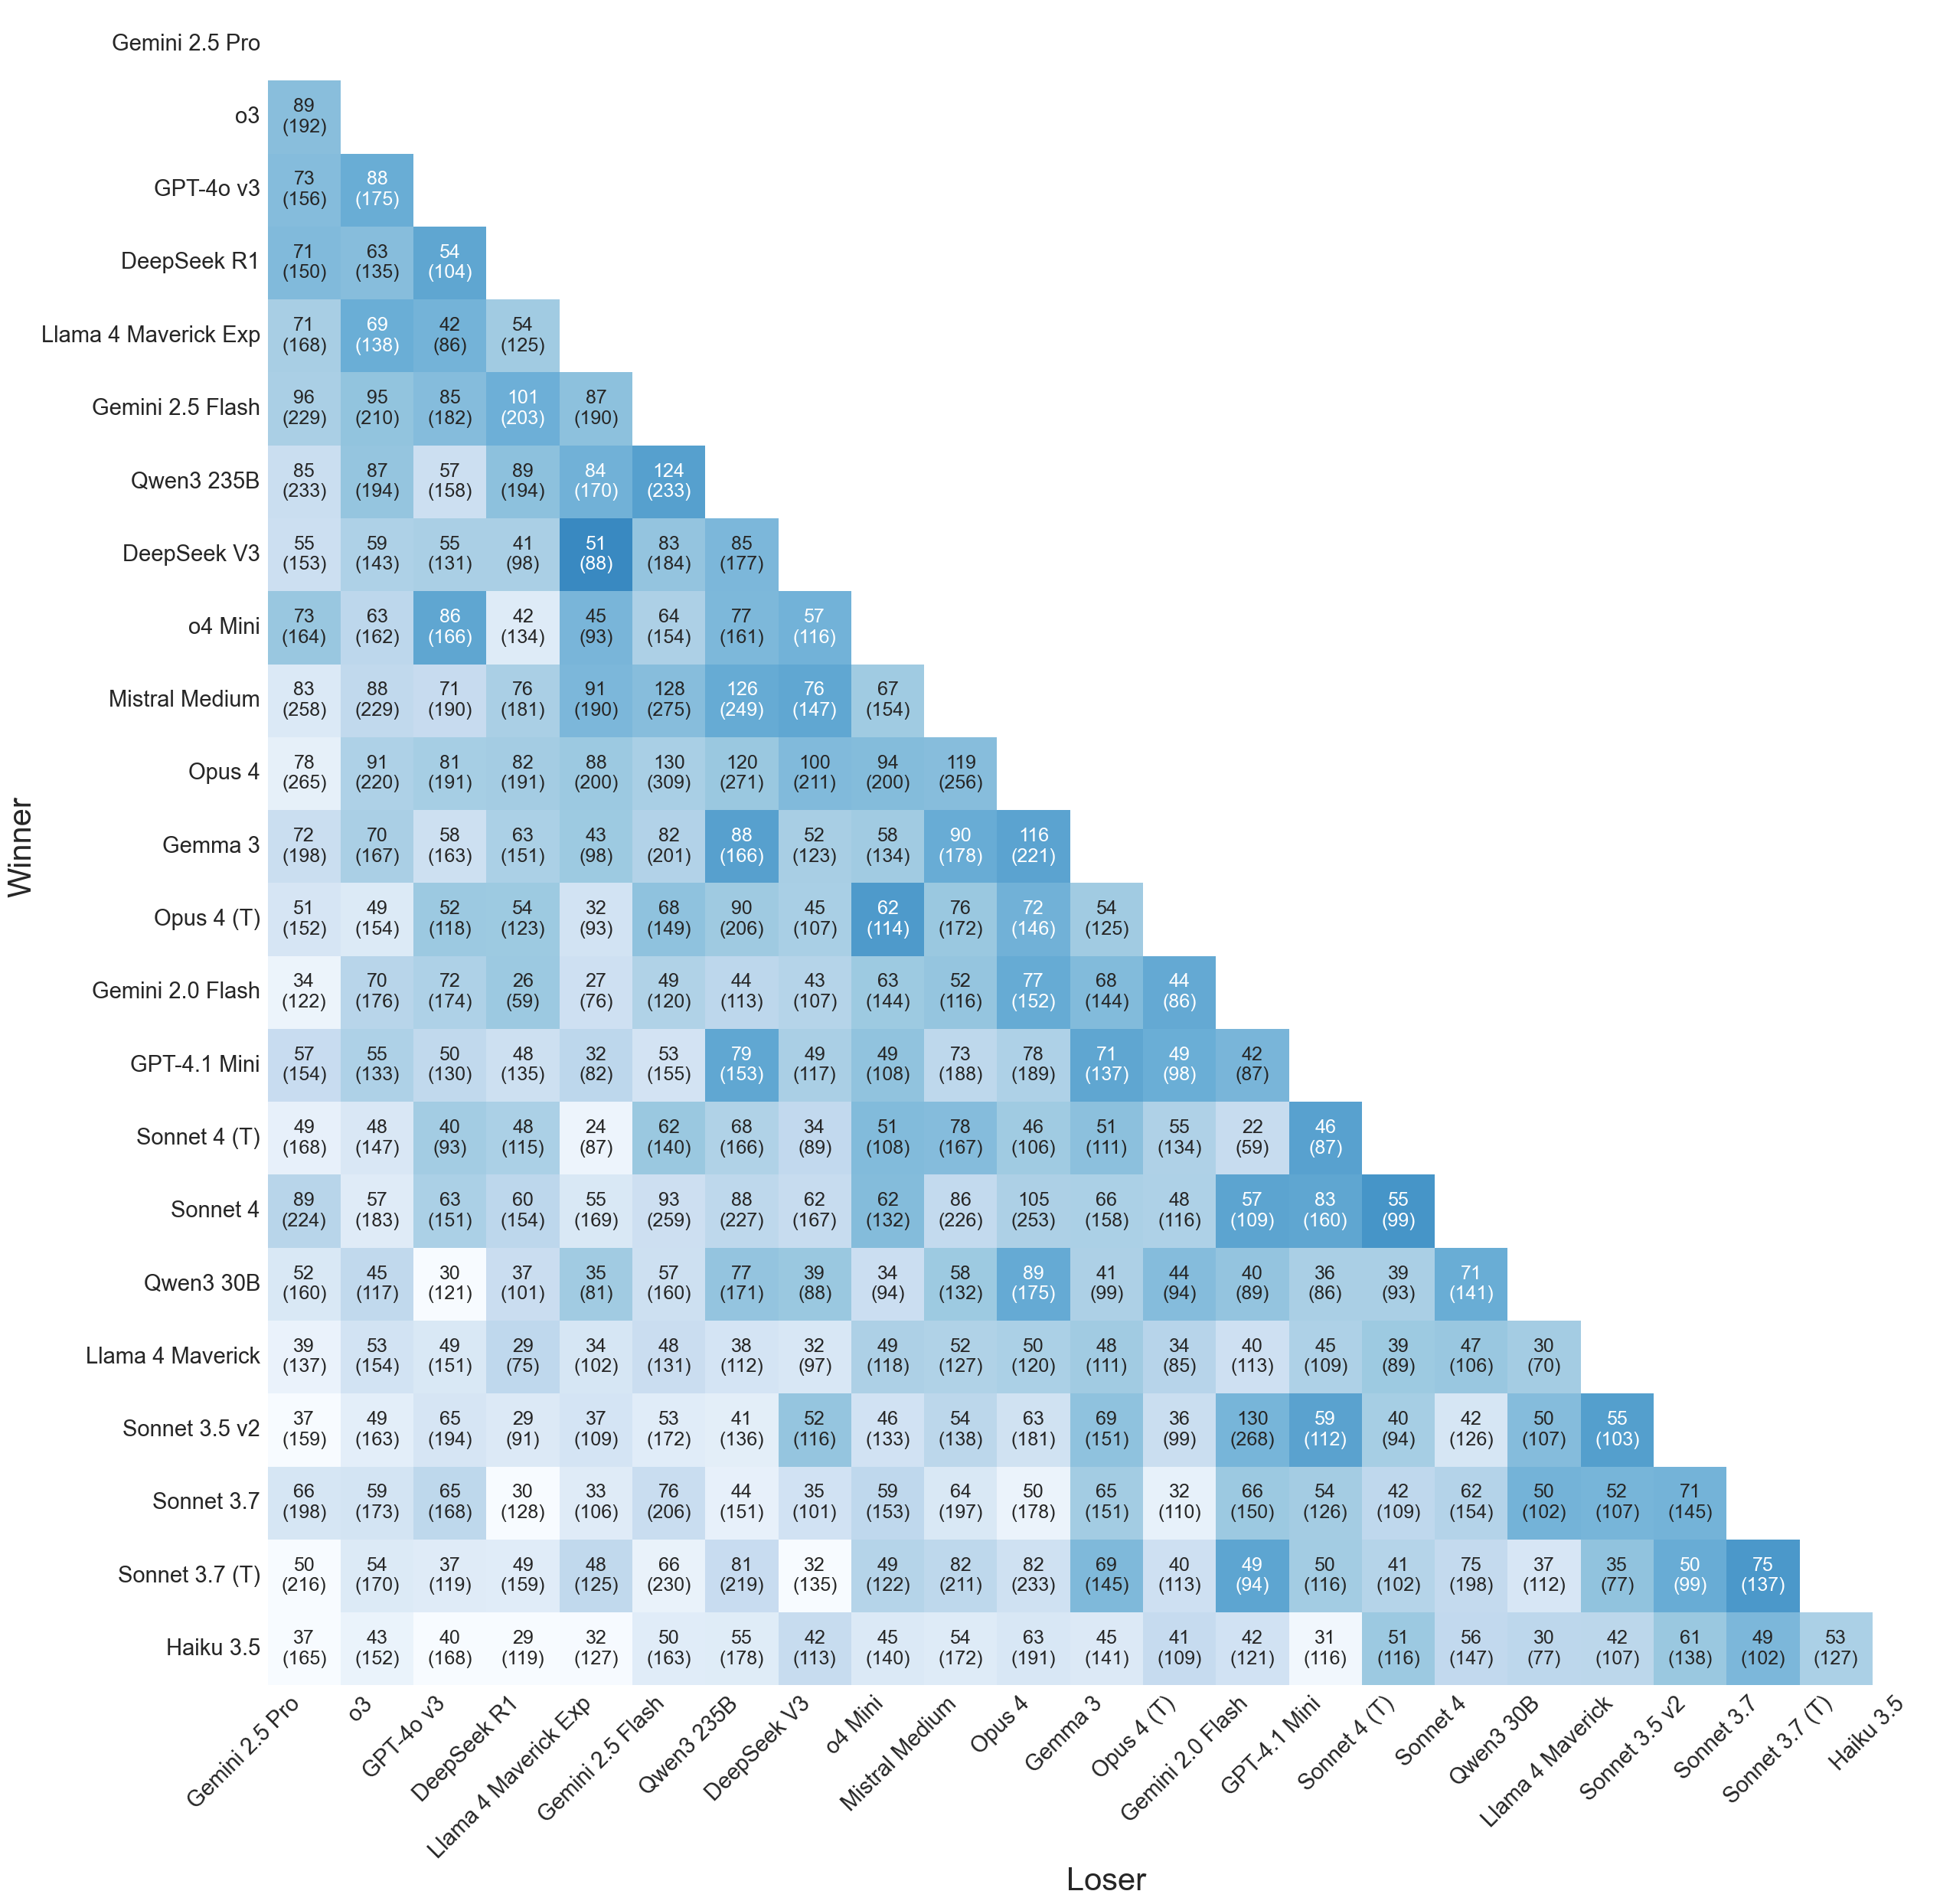

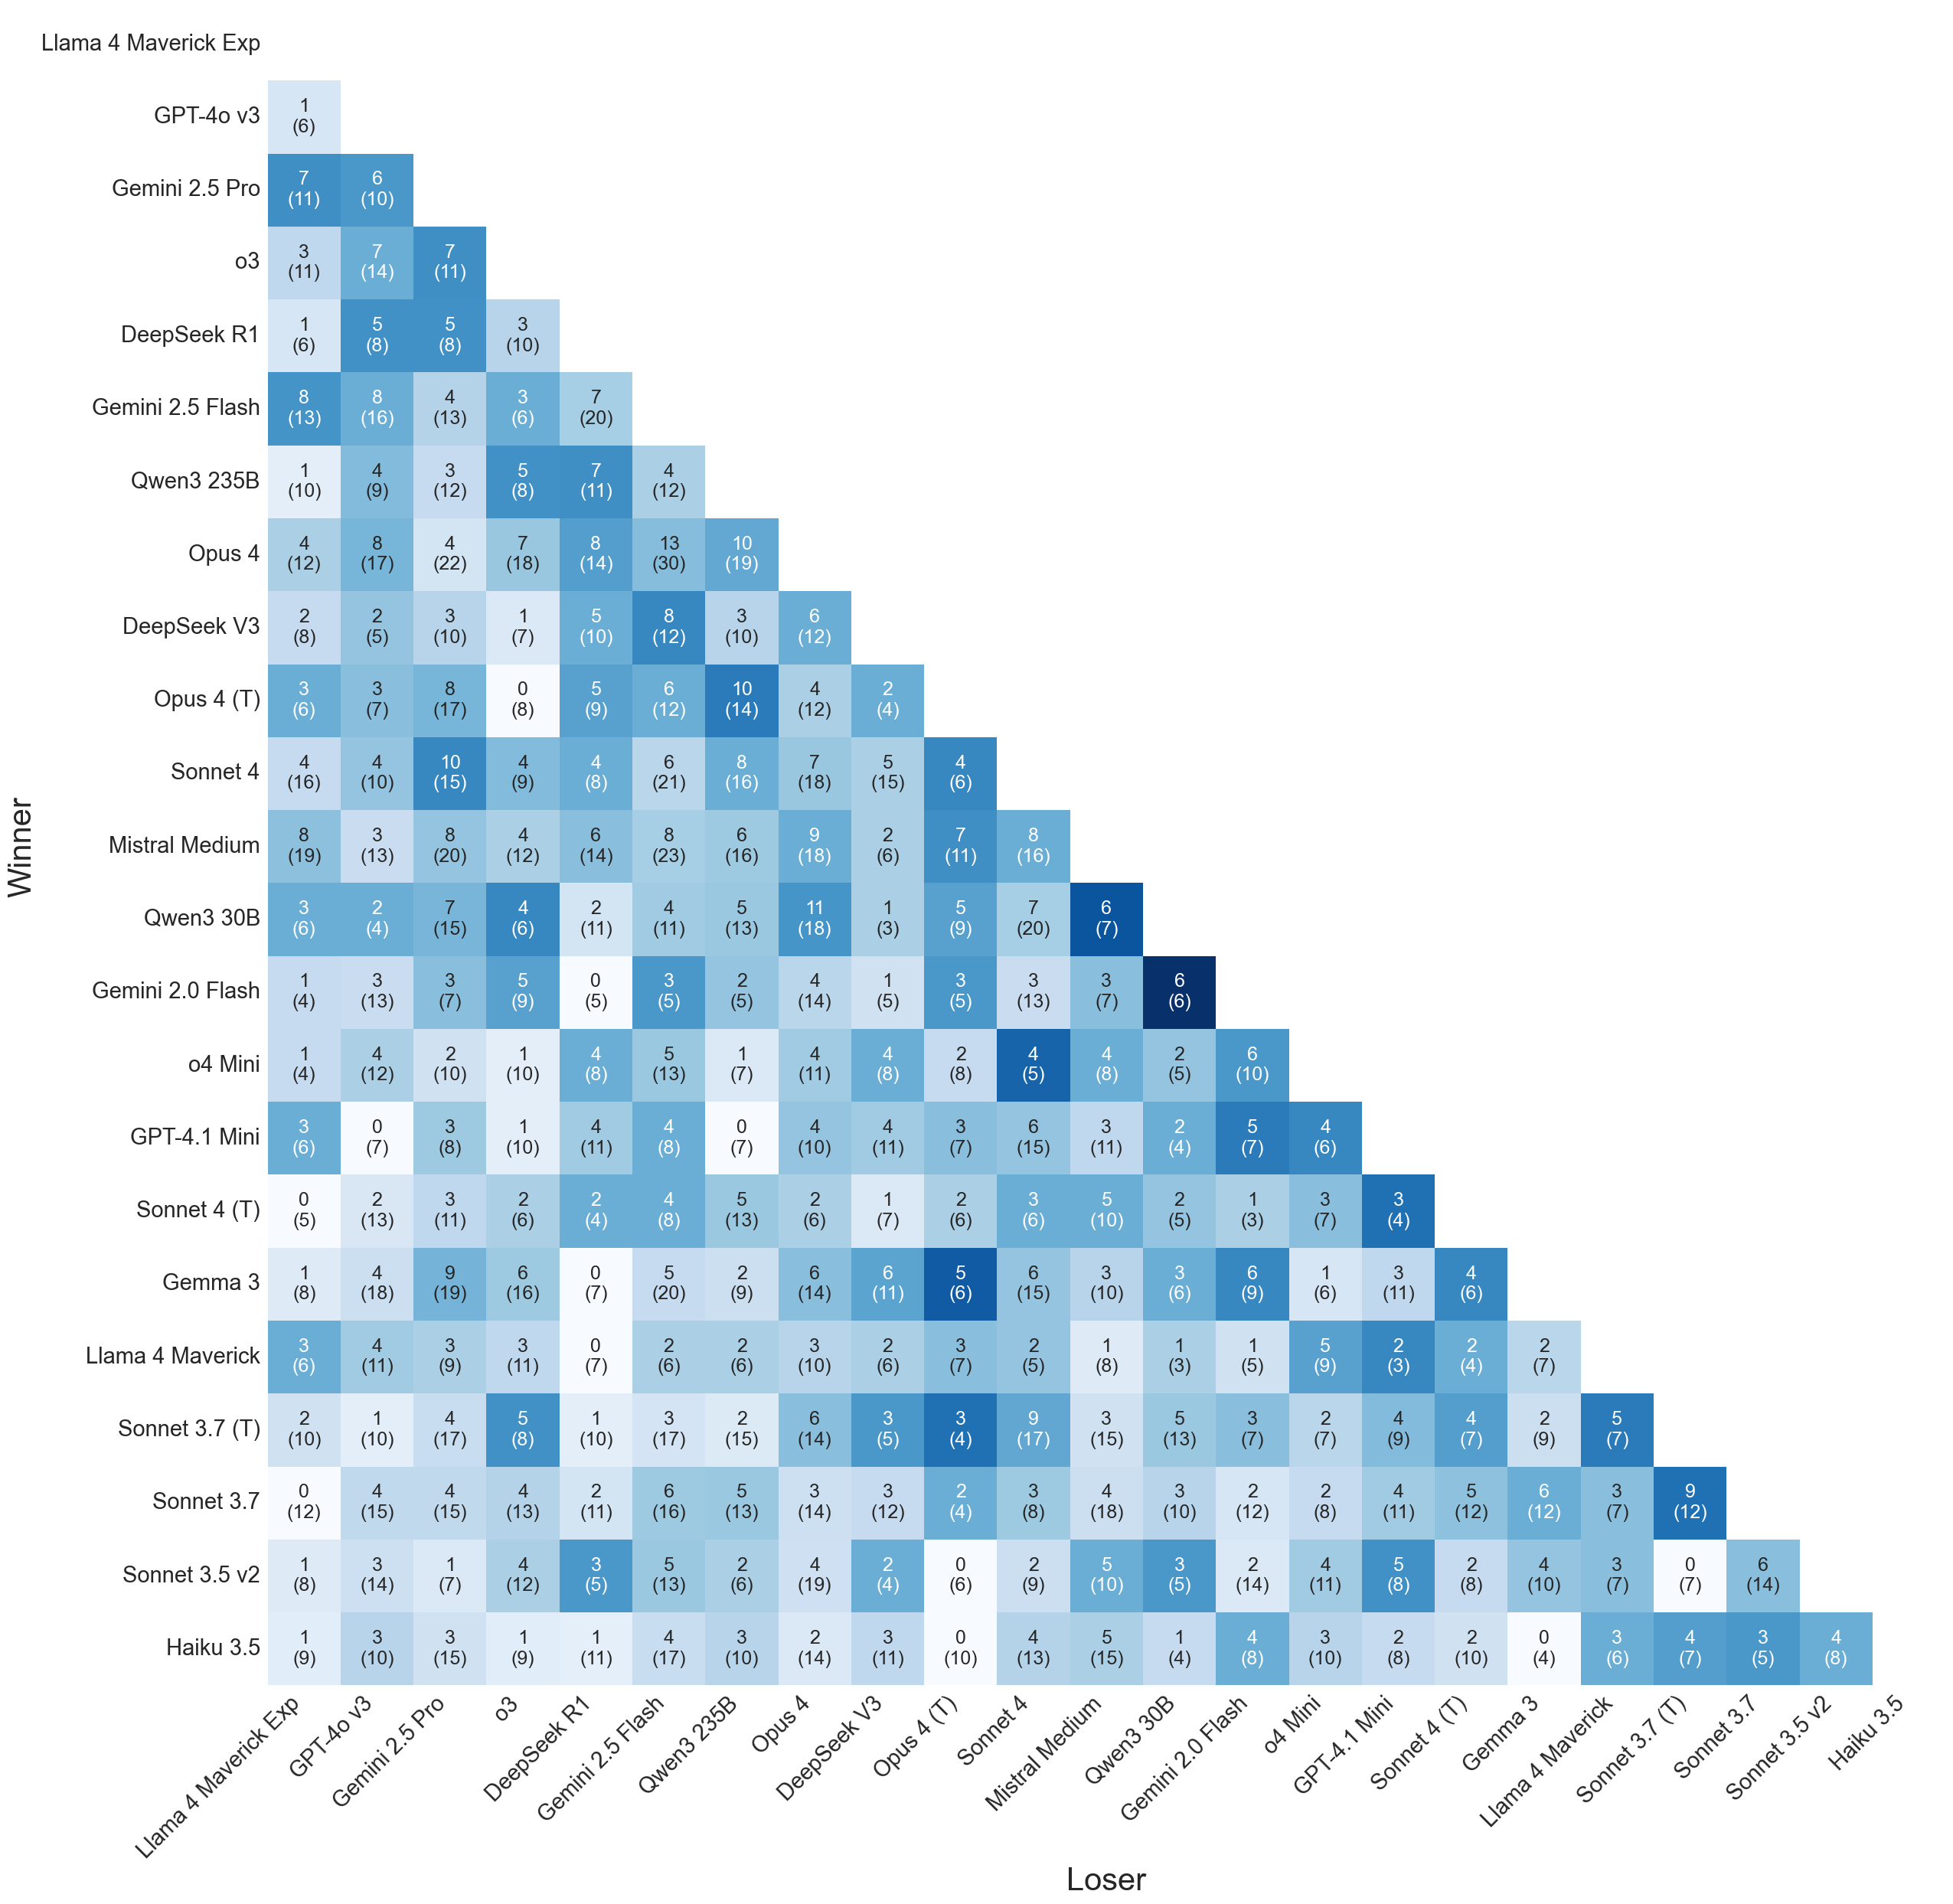

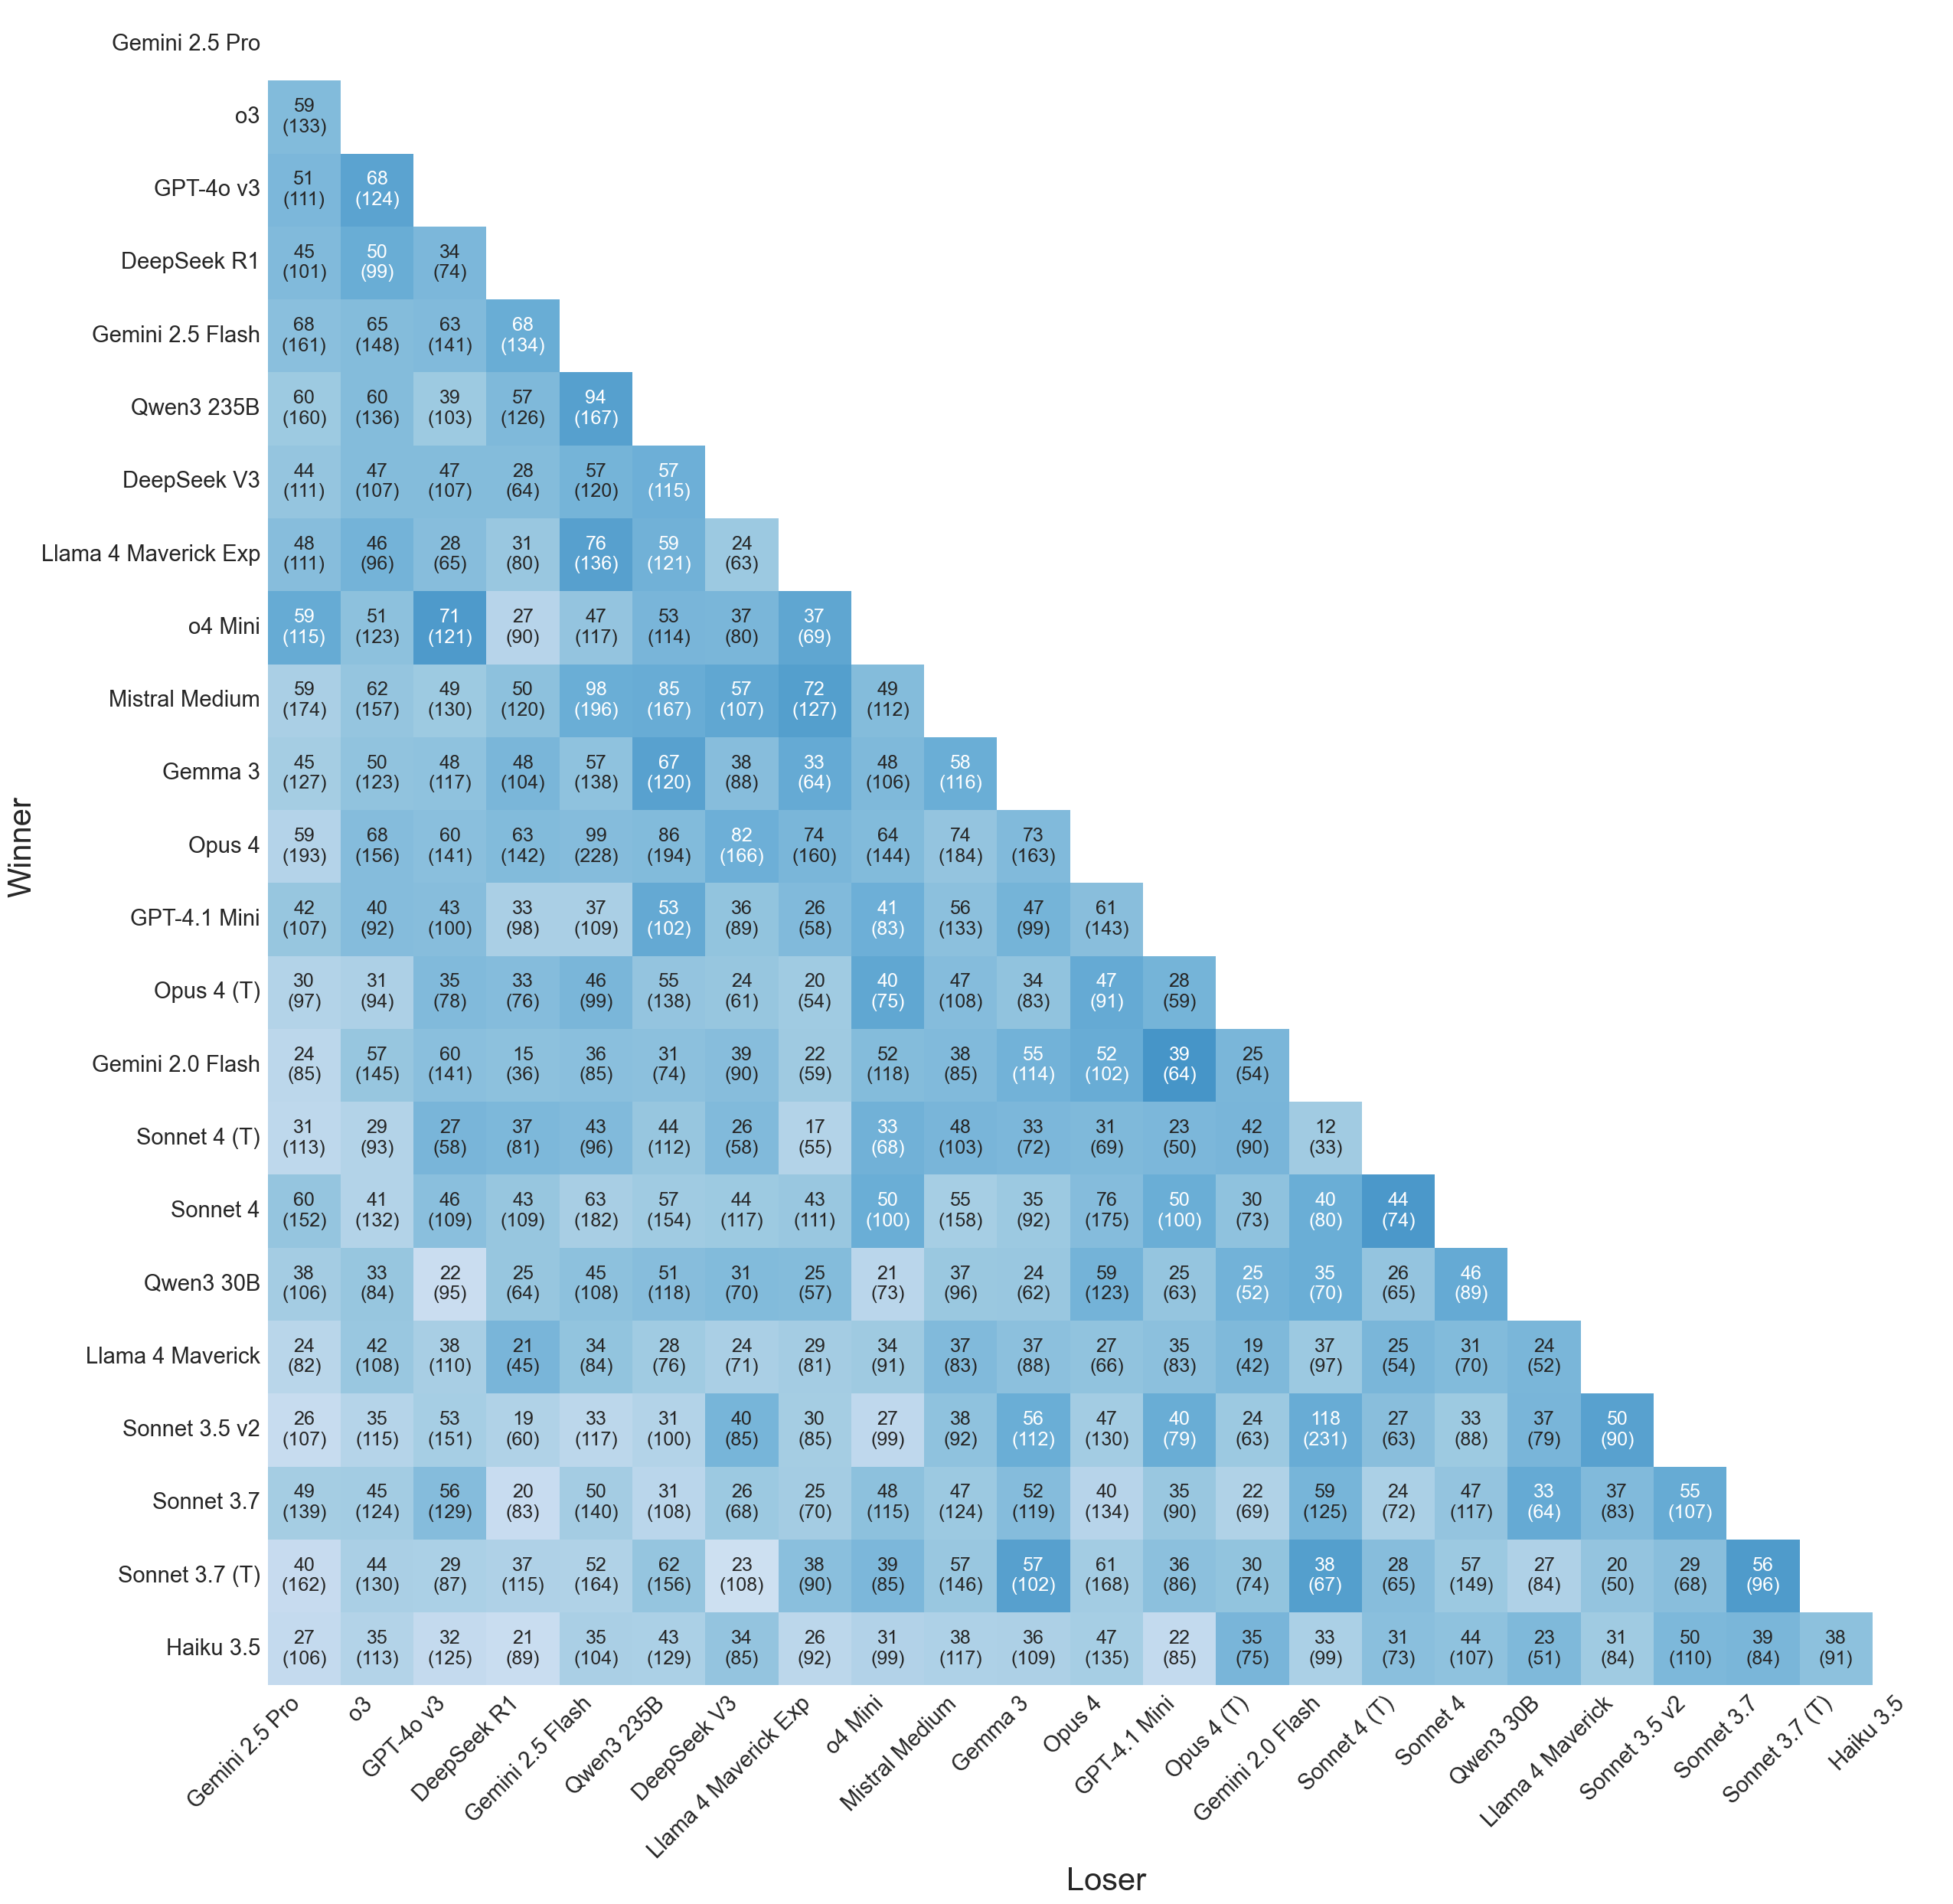

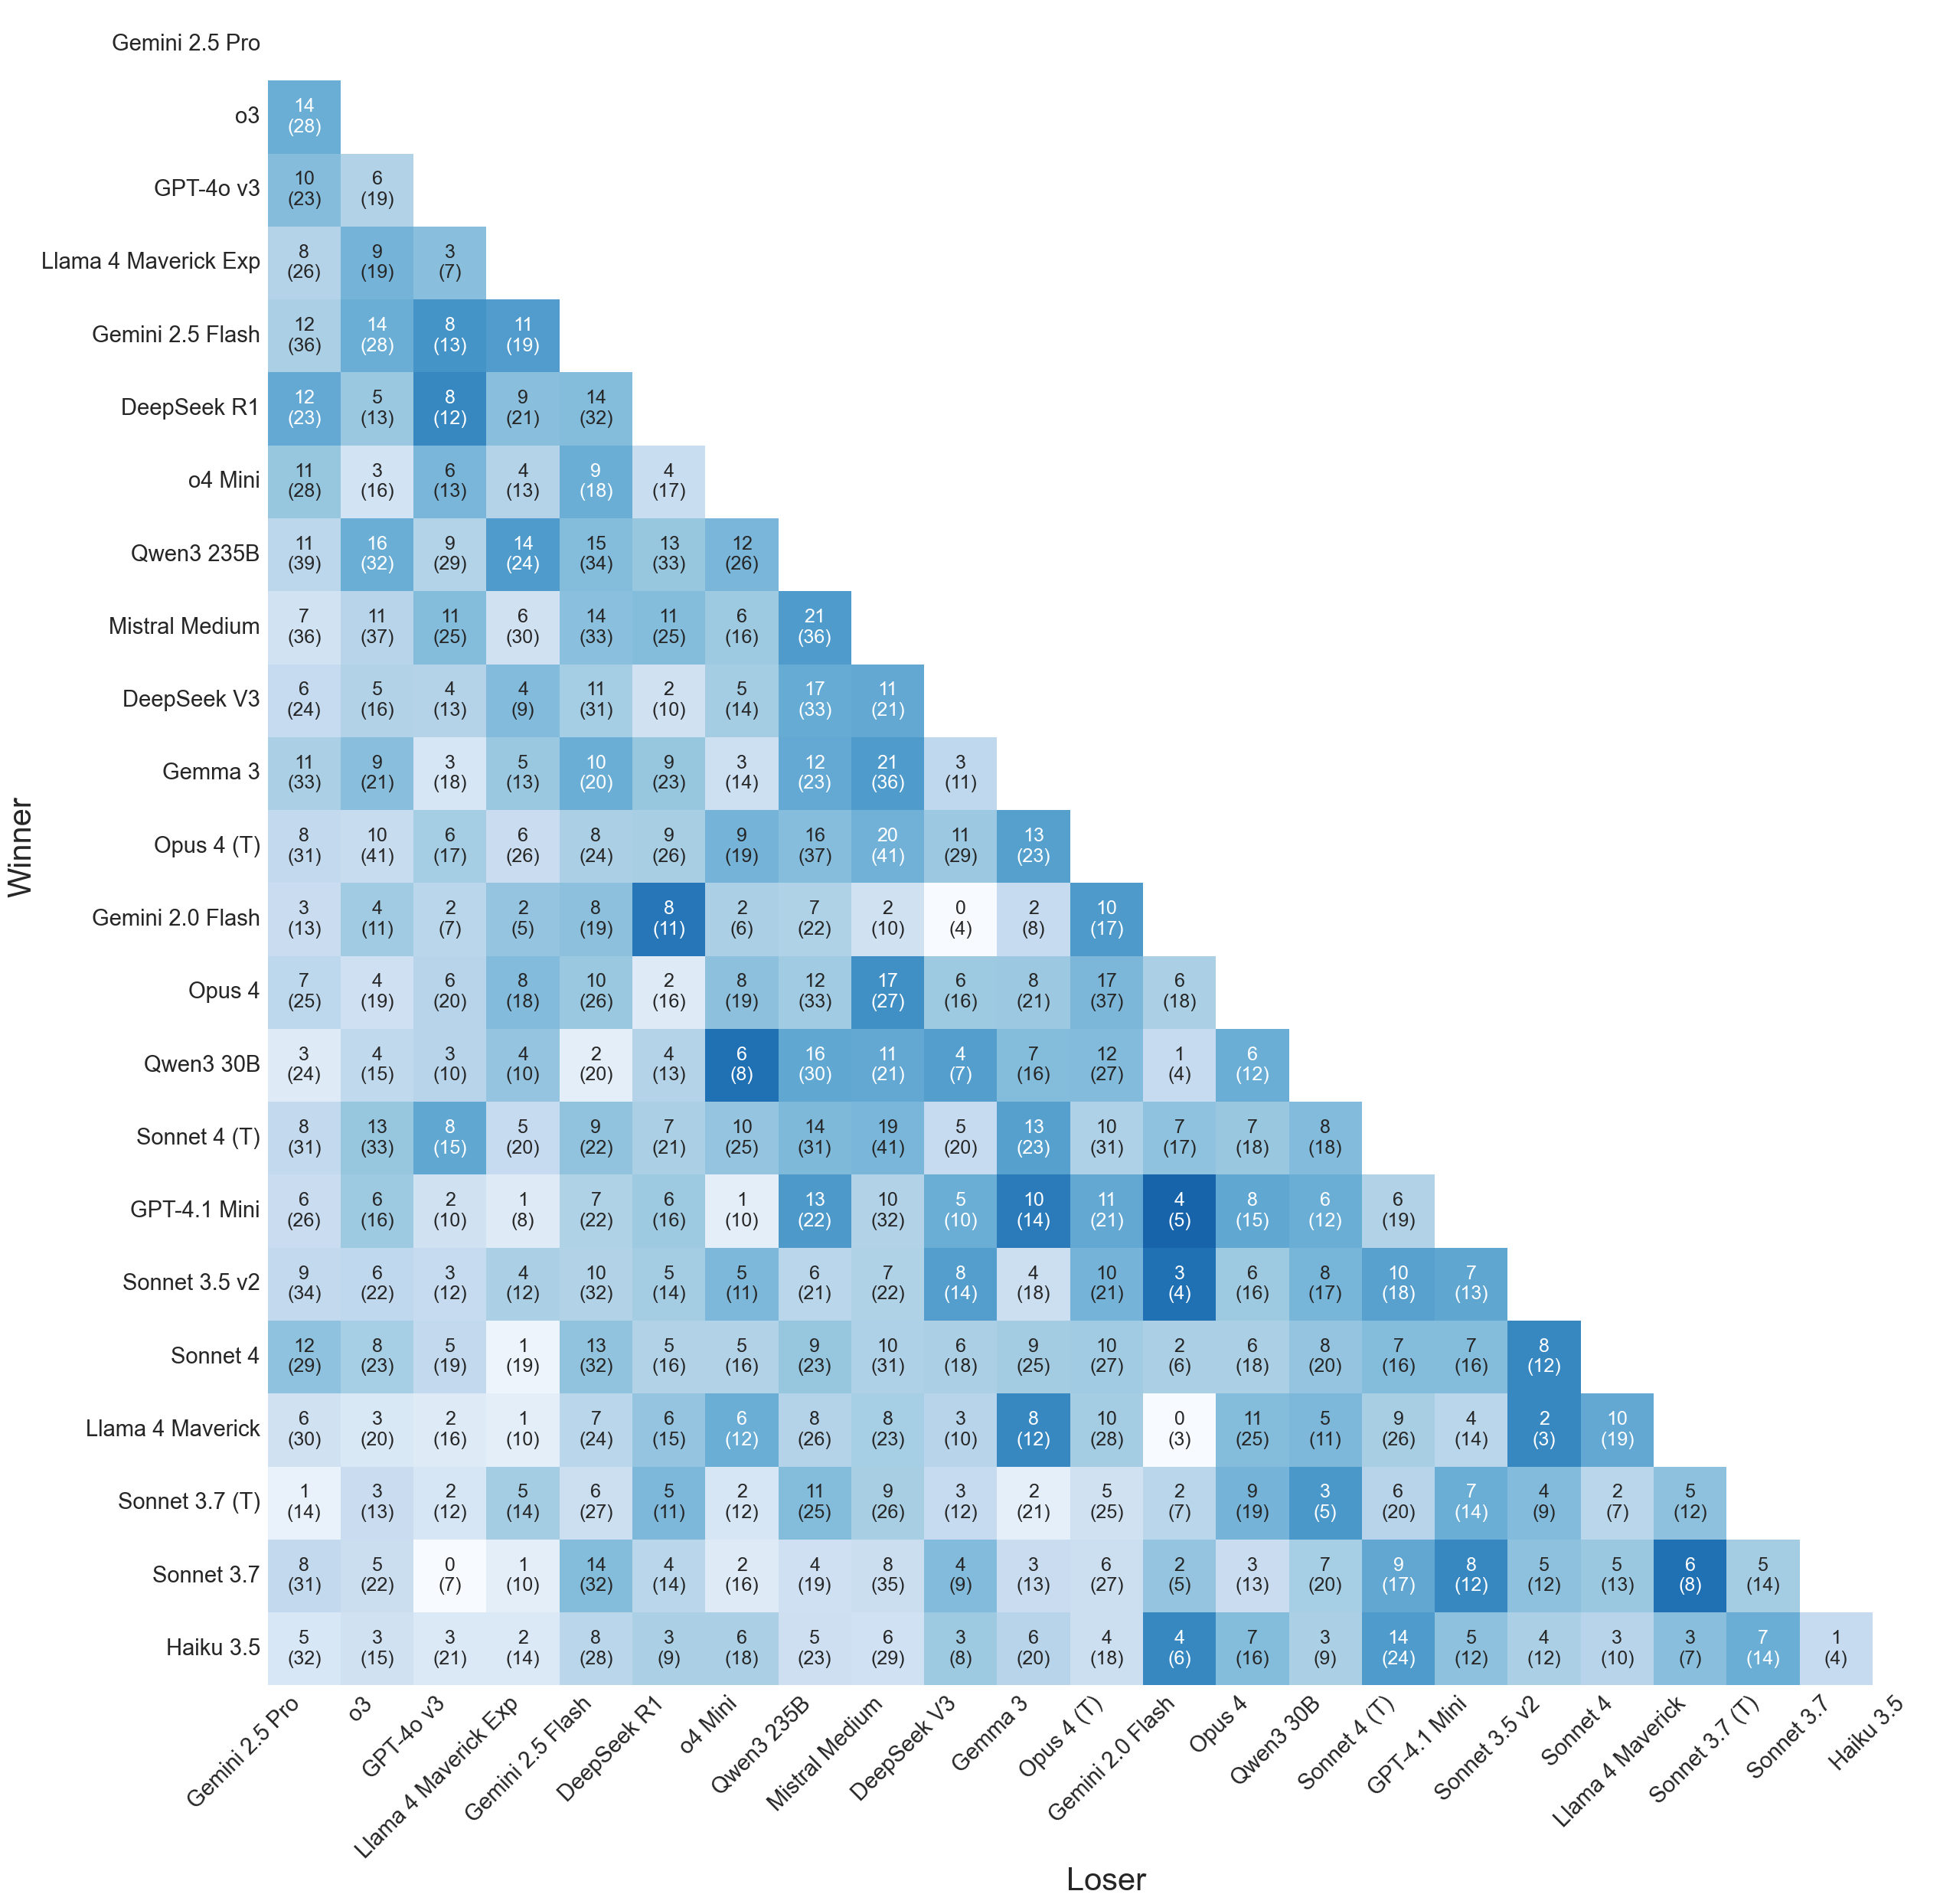

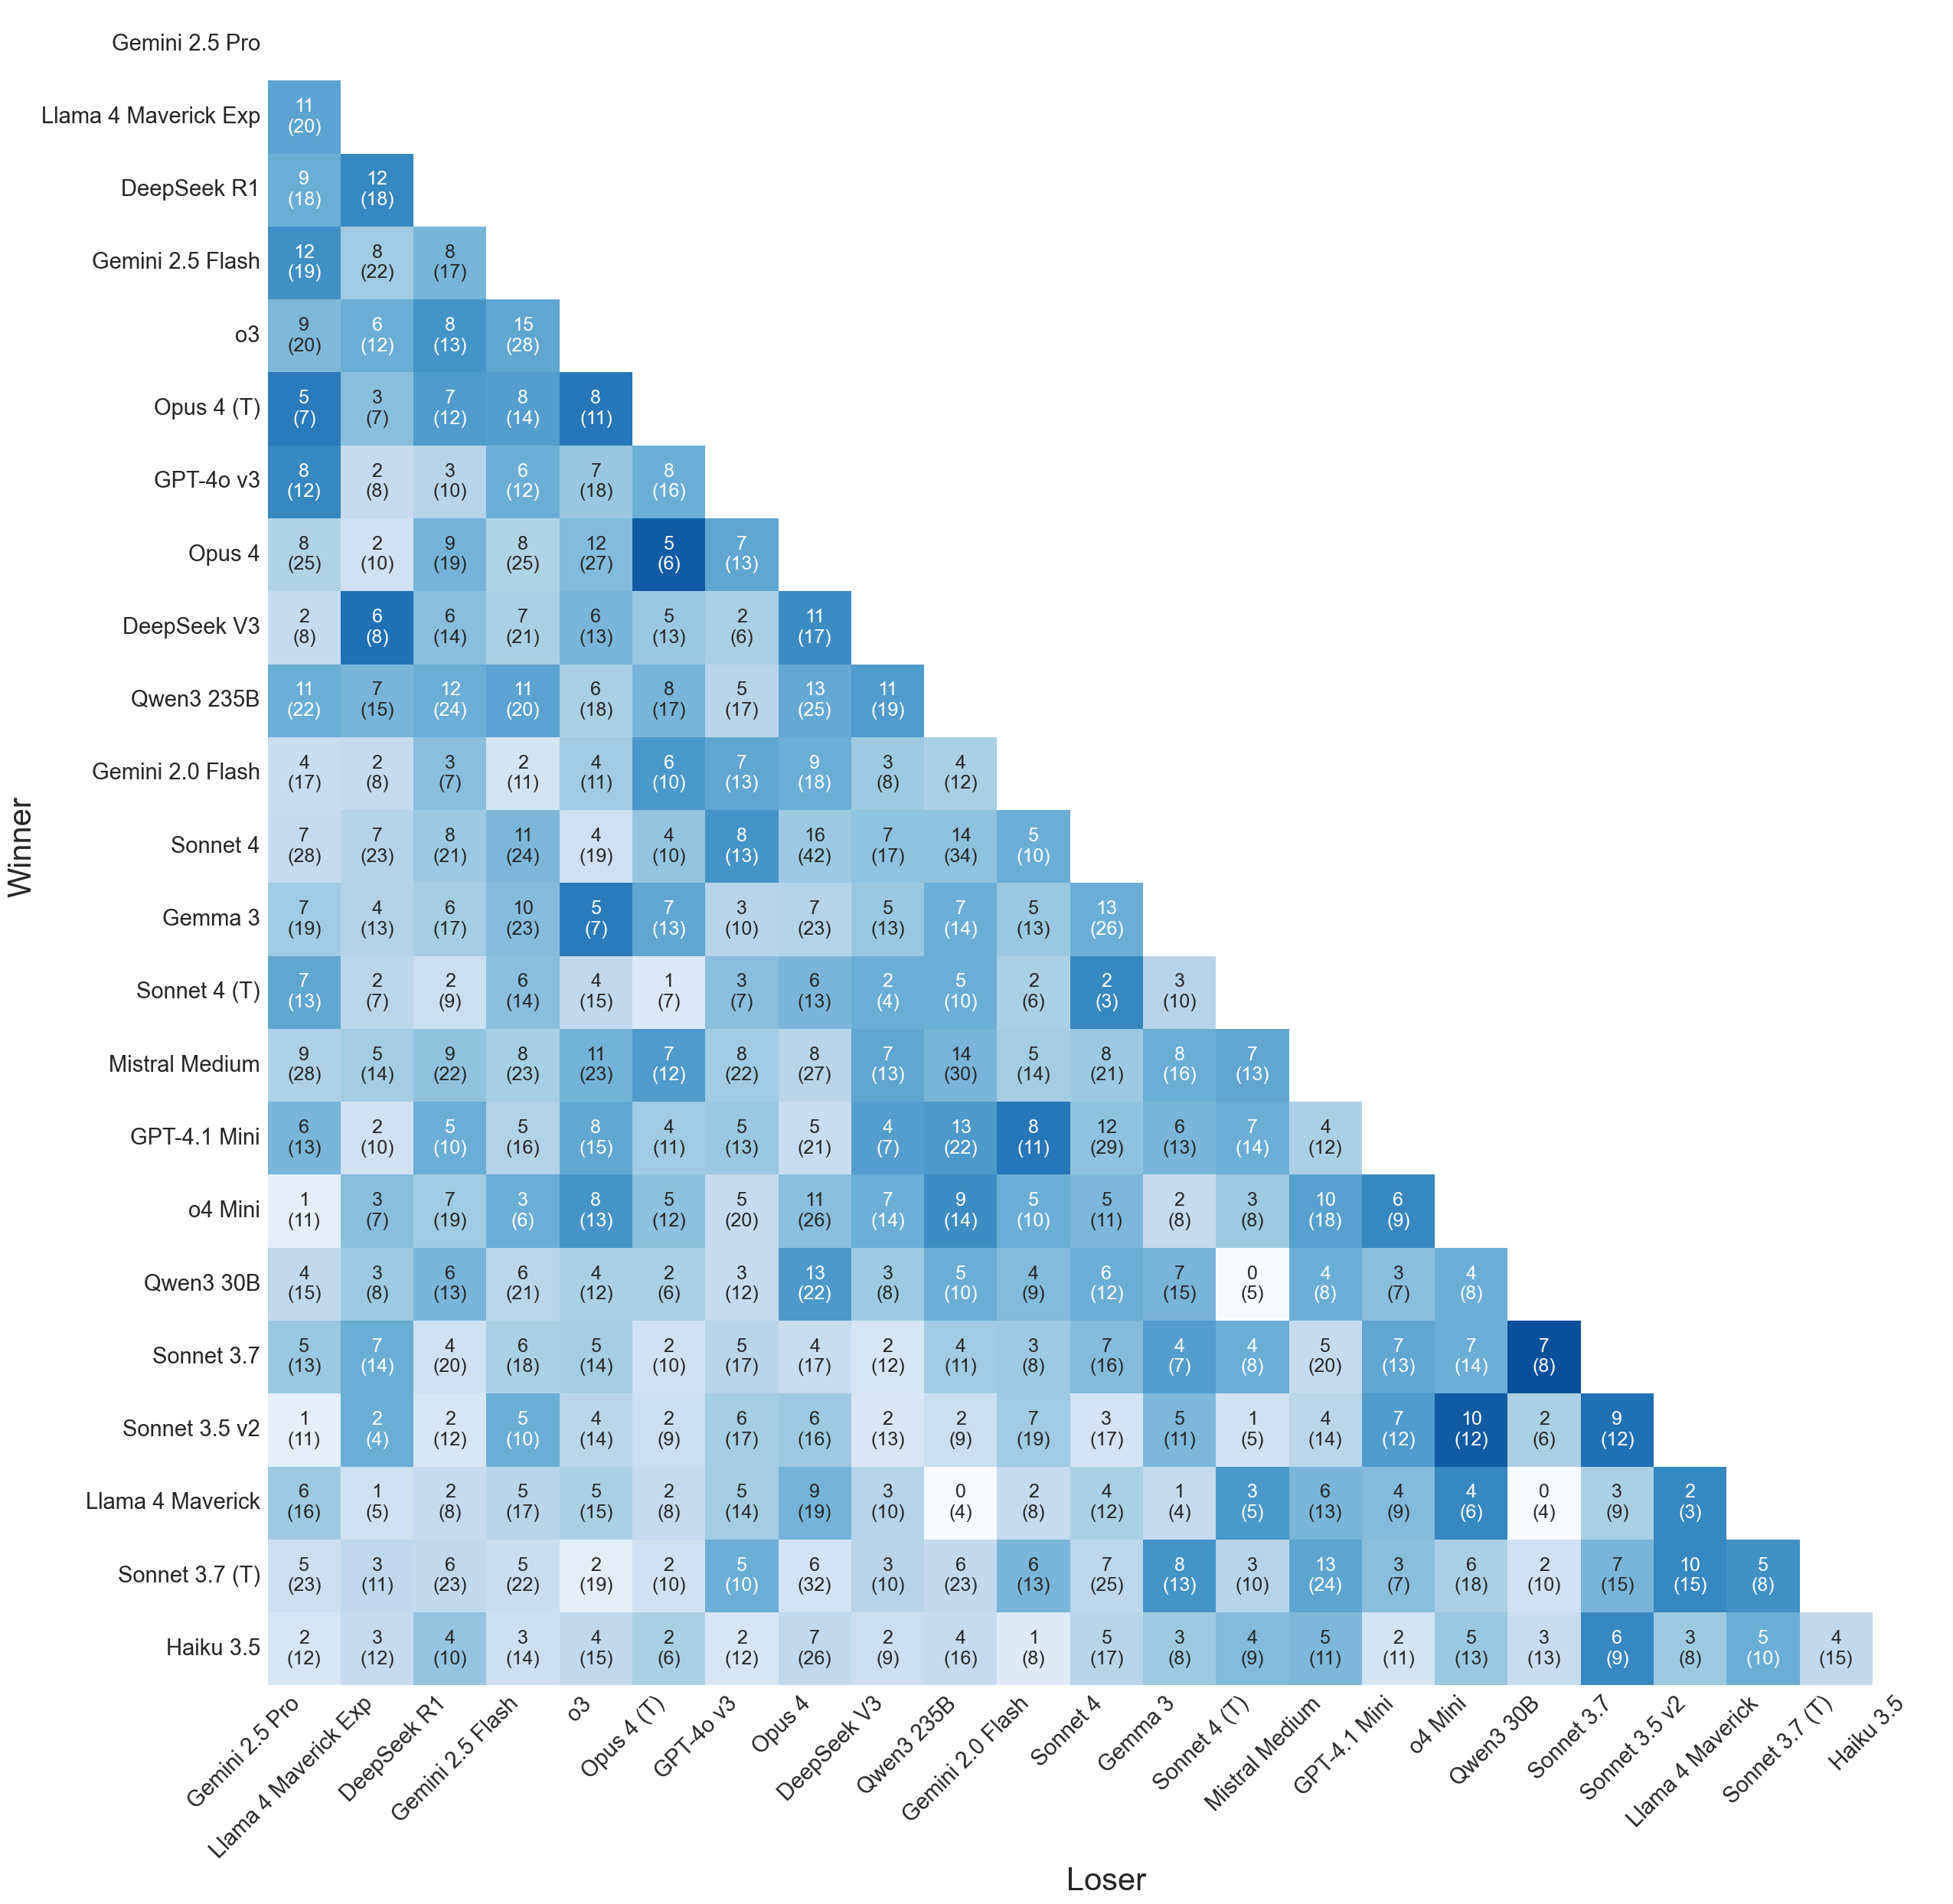

In [24]:
def plot_heatmap(M: np.ndarray, W: np.ndarray, T: np.ndarray, models: List[str], title: str, figsize: Tuple[int, int] = (150, 140), vmin: float = -0.5, vmax: float = 0.5, annot_fontsize: int = 20):
    n = M.shape[0]
    if W.shape != (n, n) or T.shape != (n, n):
        raise ValueError("M, W and T must all be square and the same shape.")
    if len(models) != n:
        models = models[:n]
        print(f"Warning: trimming 'models' to length {n} to match matrix shape.")
    winrates = []
    for i in range(n):
        total_wins = W[i, :].sum()
        total_comps = T[i, :].sum()
        winrate = total_wins / total_comps if total_comps > 0 else 0.0
        winrates.append(winrate)
    sorted_indices = sorted(range(n), key=lambda i: (winrates[i], i), reverse=True)
    sorted_models = [models[i] for i in sorted_indices]
    M_sorted = M[np.ix_(sorted_indices, sorted_indices)]
    W_sorted = W[np.ix_(sorted_indices, sorted_indices)]
    T_sorted = T[np.ix_(sorted_indices, sorted_indices)]
    display_names = [get_model_name(model) for model in sorted_models]
    plt.figure(figsize=figsize)
    annot_matrix = np.empty_like(M_sorted, dtype=object)
    for i in range(n):
        for j in range(n):
            if T_sorted[i, j] > 0:
                annot_matrix[i, j] = f"{int(W_sorted[i, j])}\n({int(T_sorted[i, j])})"
            else:
                annot_matrix[i, j] = ""
    mask = np.triu(np.ones((n, n), dtype=bool), k=0)
    ax = sns.heatmap(M_sorted, mask=mask, xticklabels=display_names, yticklabels=display_names, cmap='Blues', center=0,
                vmin=vmin, vmax=vmax, square=True, cbar=False,
                annot=annot_matrix, fmt='', annot_kws={'fontsize': annot_fontsize}, linewidths=0, linecolor= None)
    ax.set_facecolor("white")
    ax.grid(False)
    plt.grid(False)
    plt.xlabel('Loser', fontsize=30)
    plt.ylabel('Winner', fontsize=30)
    plt.xticks(rotation=45, ha='right', fontsize=21)
    plt.yticks(rotation=0, fontsize=21)
    plt.savefig(f"heatmap_lmarena_{title}.pdf", dpi=300, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

plot_heatmap(M_overall_clique, W_overall_clique, T_overall_clique, clique_models, "overall", figsize=(30, 25), annot_fontsize=18)

vmin = min(M.min() for M in M_per_category_clique.values())
vmax = max(M.max() for M in M_per_category_clique.values())

for cat in all_categories:
    plot_heatmap(M_per_category_clique[cat], W_per_category_clique[cat], T_per_category_clique[cat], clique_models,
                 f'{cat.title()}', figsize=(30, 25), annot_fontsize=18, vmin=vmin, vmax=vmax)


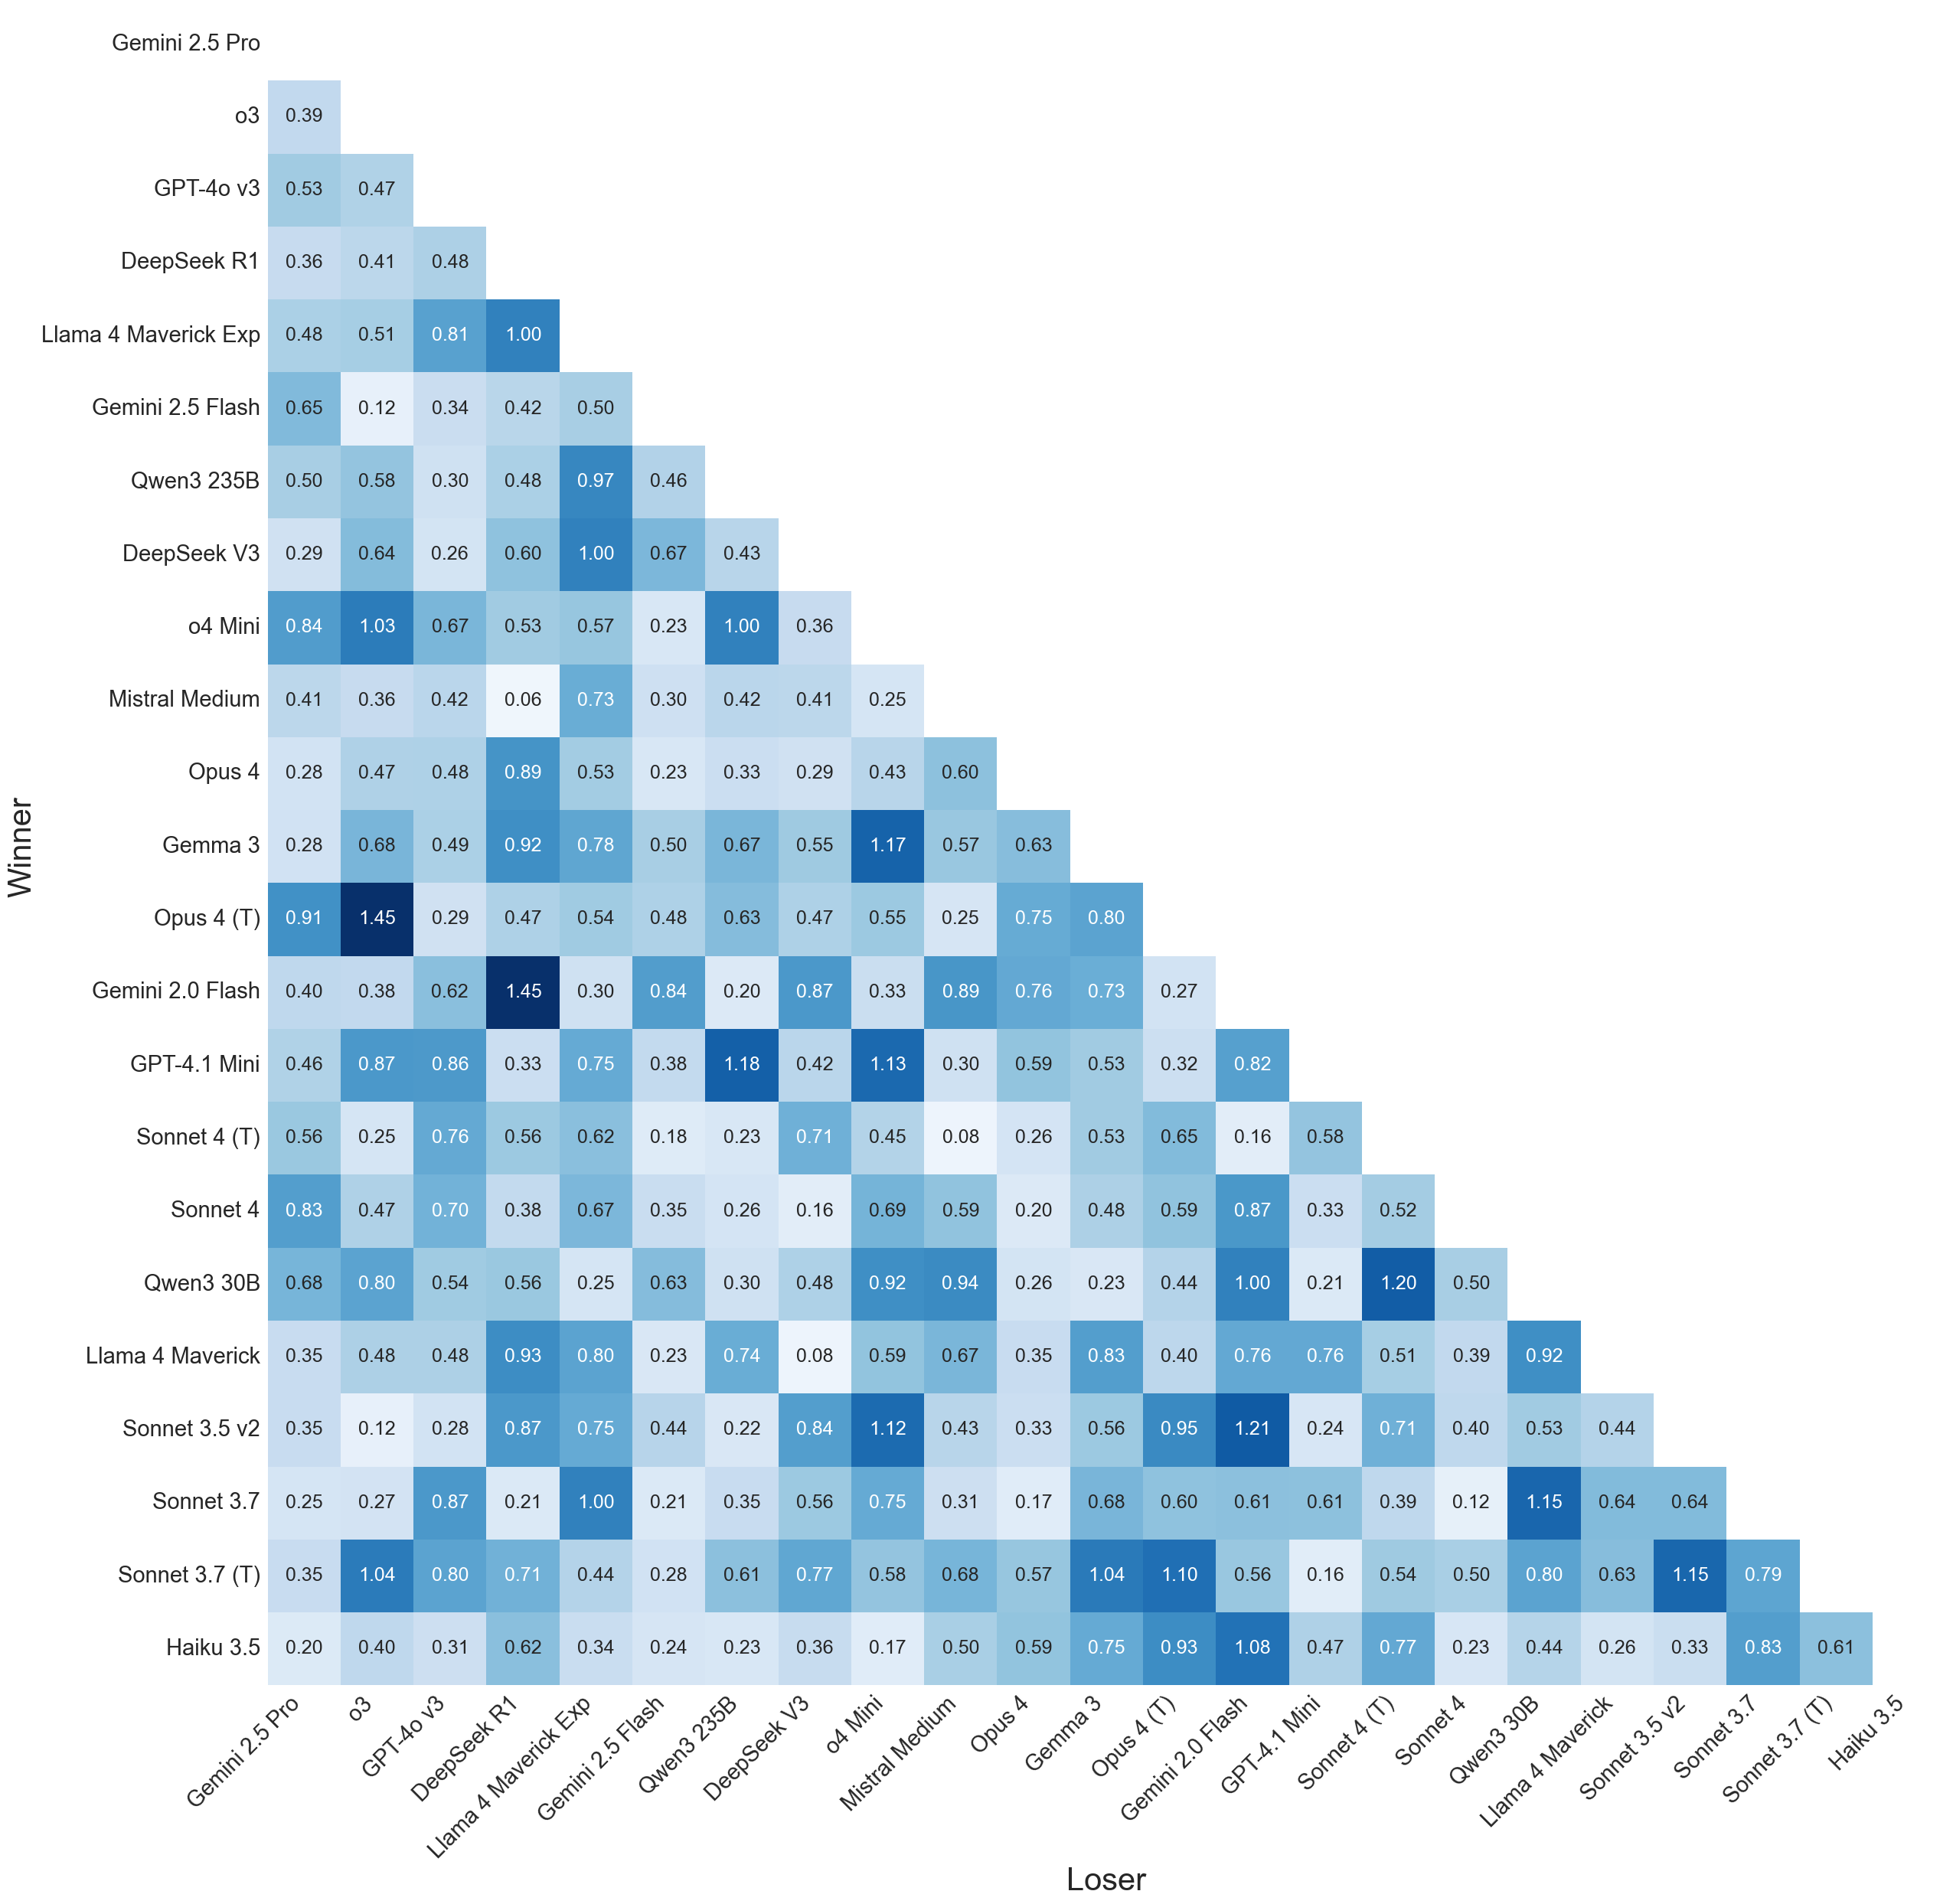

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple

def plot_heatmap_lower_triangle_clique(M_per_category_clique: Dict[str, np.ndarray], W_clique: np.ndarray, T_clique: np.ndarray, clique_models: List[str], title: str, categories: List[str] = None, figsize: Tuple[int, int] = (12, 10), vmax: float = None, annot_fontsize: int = 20):
    n = W_clique.shape[0]
    if W_clique.shape[0] != W_clique.shape[1] or T_clique.shape[0] != T_clique.shape[1] or W_clique.shape != T_clique.shape:
        raise ValueError("W_clique and T_clique must be square and of the same shape.")
    if len(clique_models) != n:
        raise ValueError(f"len(clique_models) ({len(clique_models)}) must equal W_clique.shape[0] ({n}).")
    winrates = []
    for i in range(n):
        total_wins = W_clique[i, :].sum()
        total_comps = T_clique[i, :].sum()
        winrates.append(total_wins / total_comps if total_comps > 0 else 0.0)
    sorted_indices = sorted(range(n), key=lambda i: (winrates[i], i), reverse=True)
    sorted_models = [clique_models[i] for i in sorted_indices]
    if categories is None:
        categories = list(M_per_category_clique.keys())
    valid_Ms = []
    for cat in categories:
        M = M_per_category_clique.get(cat)
        if M is None:
            continue
        M_arr = np.asarray(M)
        if M_arr.shape == (n, n):
            valid_Ms.append(M_arr)
    if len(valid_Ms) == 0:
        raise ValueError("No matrices in M_per_category_clique match the shape of W_clique/T_clique.")
    M_stack = np.stack(valid_Ms, axis=0)
    M_stack_sorted = M_stack[:, sorted_indices, :][:, :, sorted_indices]
    range_matrix = np.abs(M_stack_sorted.max(axis=0) - M_stack_sorted.min(axis=0))
    W_sorted = W_clique[np.ix_(sorted_indices, sorted_indices)]
    T_sorted = T_clique[np.ix_(sorted_indices, sorted_indices)]
    display_names = [get_model_name(model) for model in sorted_models]
    vmin = 0.0
    if vmax is None:
        vmax = float(range_matrix.max())
    if vmax == 0.0:
        vmax = 1e-6
    center = (vmin + vmax) / 2.0
    mask = np.triu(np.ones_like(range_matrix, dtype=bool))  # mask upper triangle including diagonal
    annot_matrix = np.full(range_matrix.shape, "", dtype=object)
    for i in range(n):
        for j in range(n):
            if not mask[i, j] and T_sorted[i, j] > 0:
                annot_matrix[i, j] = f"{range_matrix[i, j]:.2f}"
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_facecolor("white")
    ax.grid(False)
    plt.grid(False)
    sns.heatmap(range_matrix, mask=mask, xticklabels=display_names, yticklabels=display_names, cmap='Blues', vmin=vmin, vmax=vmax, center=center, square=True, cbar=False, annot=annot_matrix, fmt='', annot_kws={'fontsize': annot_fontsize}, ax=ax)
    ax.set_xlabel('Loser', fontsize=30)
    ax.set_ylabel('Winner', fontsize=30)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=21)
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=21)
    plt.tight_layout()
    plt.savefig(f"heatmap_winrate.pdf", dpi=300, bbox_inches='tight')
    plt.show()

plot_heatmap_lower_triangle_clique(M_per_category_clique, W_overall_clique, T_overall_clique, clique_models, 'Range of M across categories (Clique) - Lower Triangle', categories=all_categories, figsize=(30, 25), annot_fontsize=18)


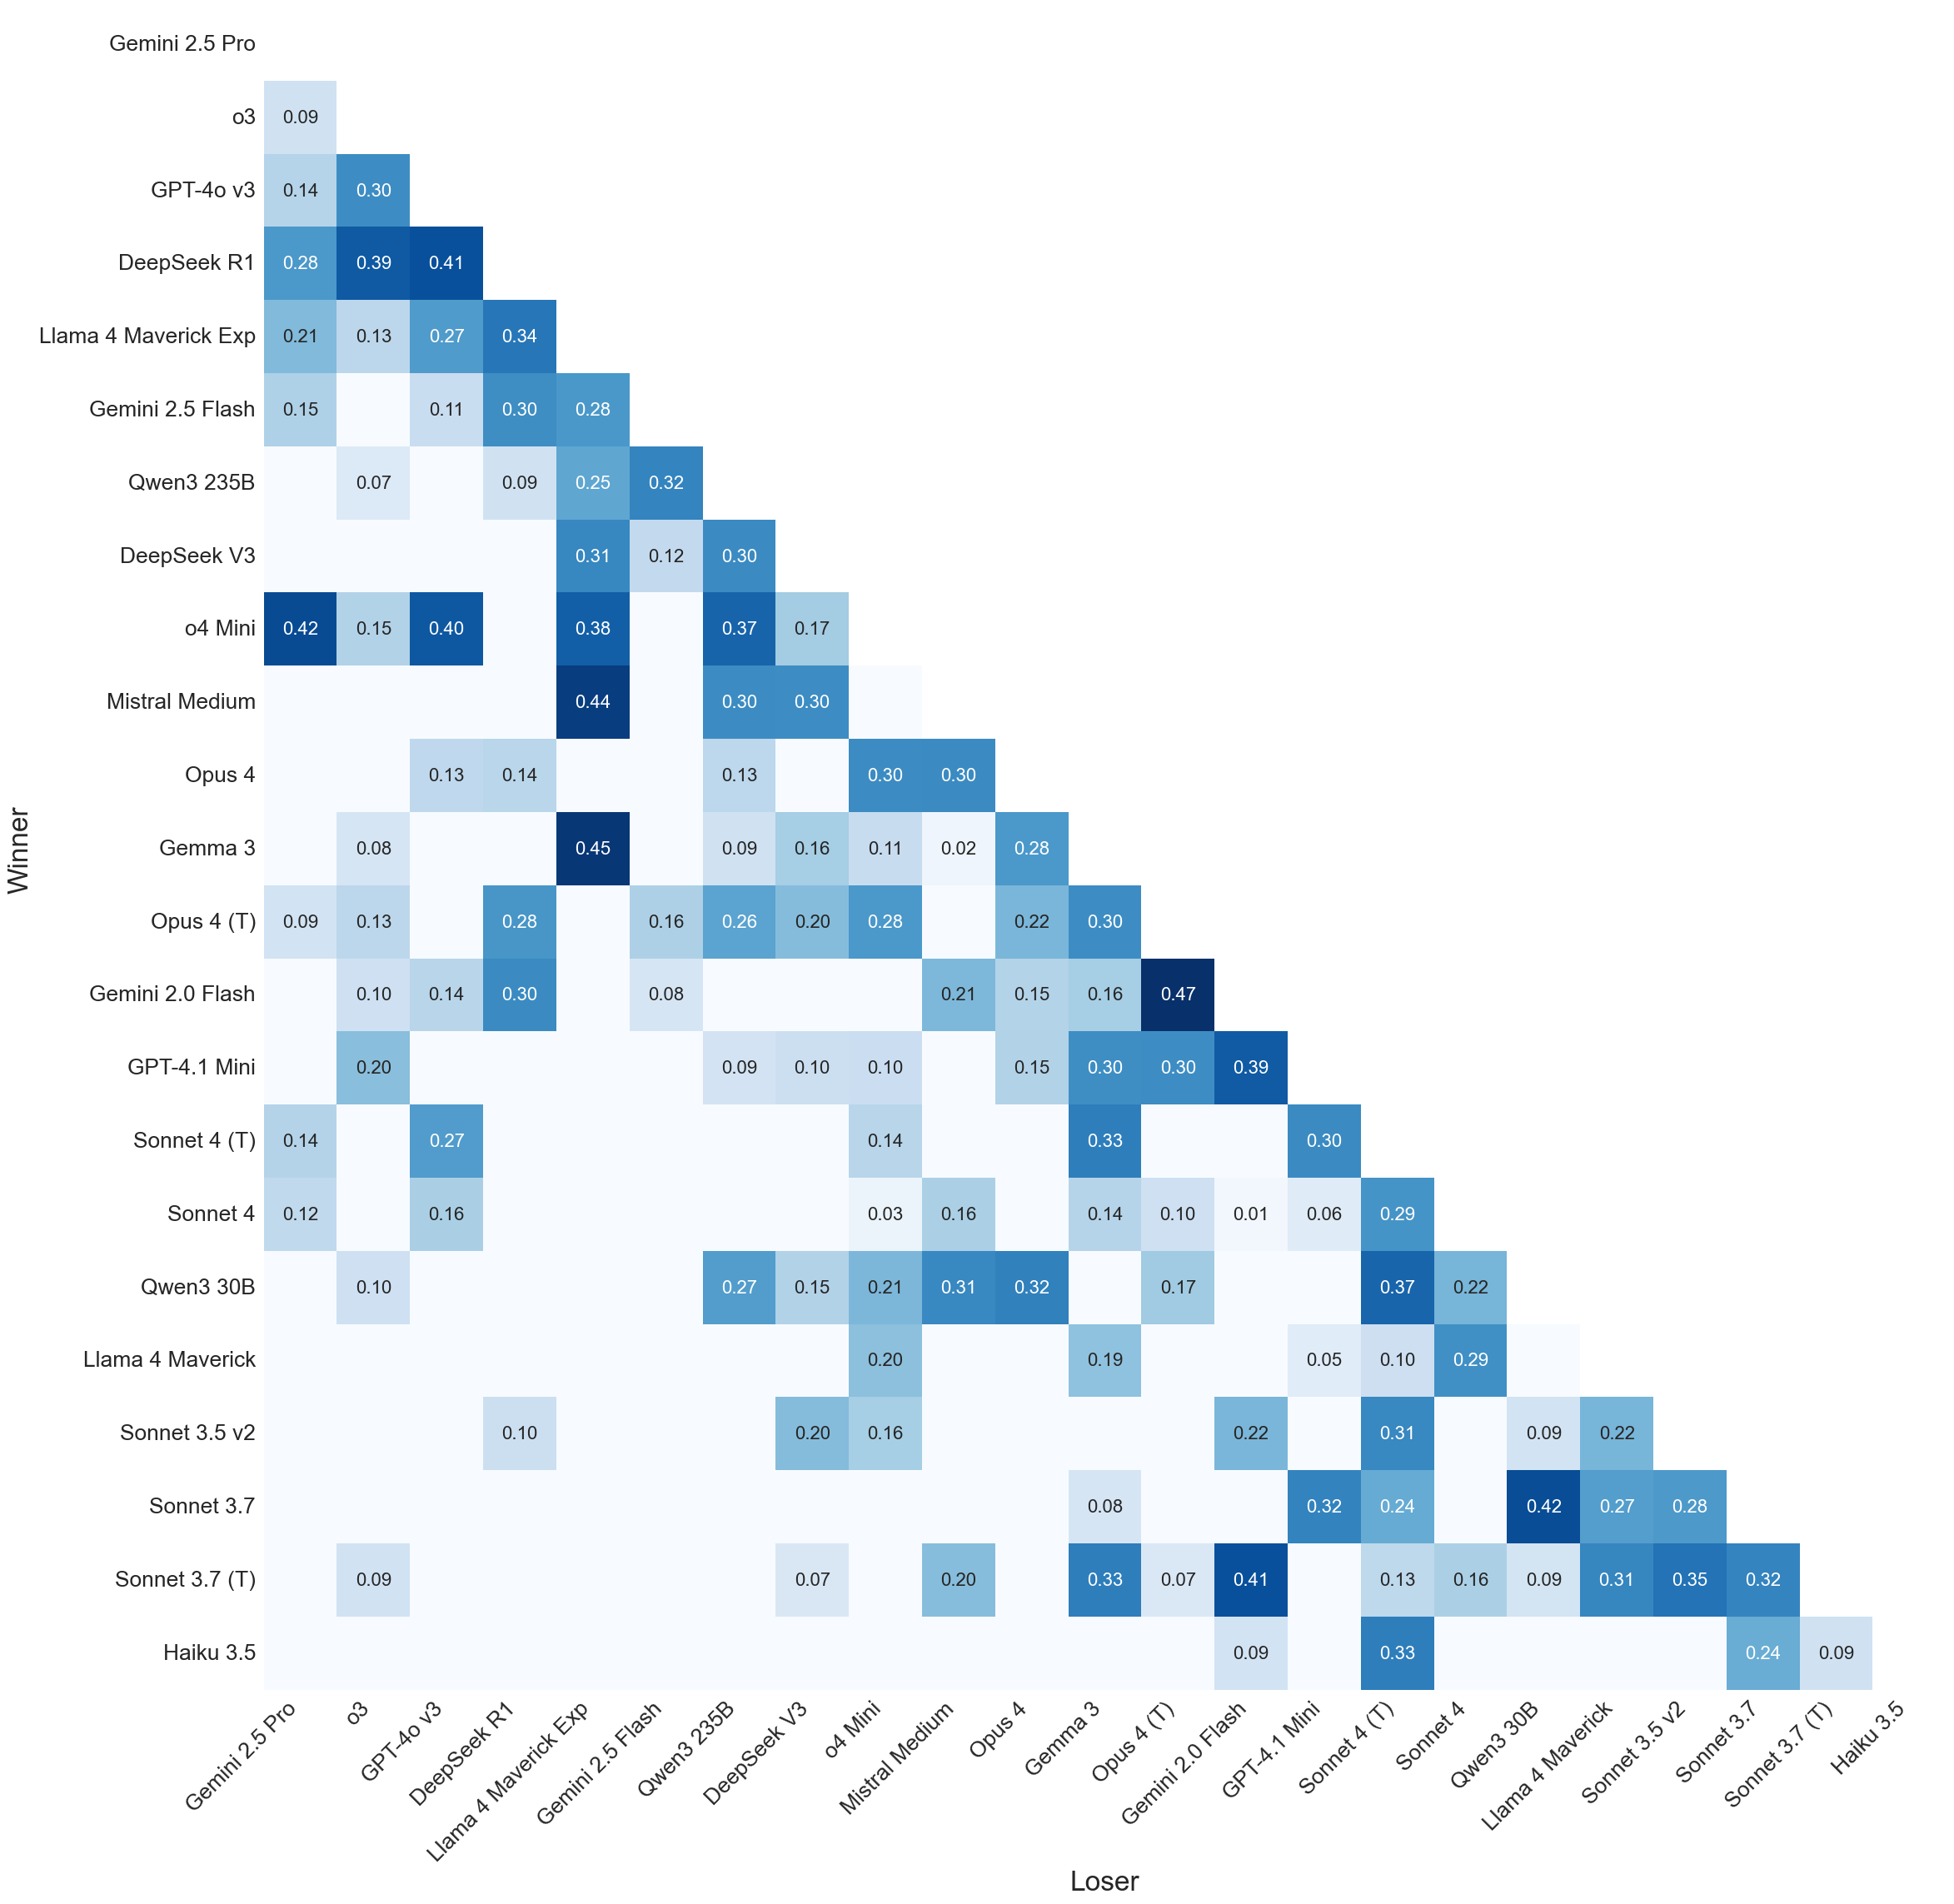

In [27]:
def _prob_opposite_uniform_without_replacement(M_stack: np.ndarray) -> np.ndarray:
    C = M_stack.shape[0]
    if C < 2:
        return np.zeros(M_stack.shape[1:])
    pos = (M_stack > 0).sum(axis=0)
    neg = (M_stack < 0).sum(axis=0)
    return 2.0 * pos * neg / (C * (C - 1))

def _prob_opposite_weighted_by_counts(M_stack: np.ndarray, T_stack: np.ndarray) -> np.ndarray:
    Ts_total = T_stack.sum(axis=0)
    pos_weights = np.where(M_stack > 0, T_stack, 0).sum(axis=0)
    neg_weights = np.where(M_stack < 0, T_stack, 0).sum(axis=0)
    with np.errstate(divide='ignore', invalid='ignore'):
        p_pos = pos_weights / Ts_total
        p_neg = neg_weights / Ts_total
        prob = 2.0 * p_pos * p_neg
    prob = np.nan_to_num(prob, nan=0.0)
    return prob

def plot_heatmap_lower_triangle_clique(
    M_per_category_clique: Dict[str, np.ndarray],
    T_per_category_clique: Dict[str, np.ndarray],
    W_clique: np.ndarray,
    T_clique: np.ndarray,
    clique_models: List[str],
    title: str,
    categories: List[str] = None,
    figsize: Tuple[int, int] = (30, 25),
    annot_fontsize: int = 16,
    mode: str = "both",   # "uniform", "weighted", or "both"
    cmap: str = "Blues",
):
    n = W_clique.shape[0]
    if W_clique.shape[0] != W_clique.shape[1] or T_clique.shape[0] != T_clique.shape[1] or W_clique.shape != T_clique.shape:
        raise ValueError("W_clique and T_clique must be square and of the same shape.")
    if len(clique_models) != n:
        raise ValueError(f"len(clique_models) ({len(clique_models)}) must equal W_clique.shape[0] ({n}).")

    winrates = []
    for i in range(n):
        total_wins = W_clique[i, :].sum()
        total_comps = T_clique[i, :].sum()
        winrates.append(total_wins / total_comps if total_comps > 0 else 0.0)
    sorted_indices = sorted(range(n), key=lambda i: (winrates[i], i), reverse=True)
    sorted_models = [clique_models[i] for i in sorted_indices]

    if categories is None:
        categories = list(M_per_category_clique.keys())

    valid_Ms = []
    valid_Ts = []
    for cat in categories:
        M = M_per_category_clique.get(cat)
        Tc = T_per_category_clique.get(cat)
        if M is None or Tc is None:
            continue
        M_arr = np.asarray(M)
        T_arr = np.asarray(Tc)
        if M_arr.shape == (n, n) and T_arr.shape == (n, n):
            valid_Ms.append(M_arr)
            valid_Ts.append(T_arr)
    if len(valid_Ms) == 0:
        raise ValueError("No matrices in M_per_category_clique match the shape of W_clique/T_clique.")

    M_stack = np.stack(valid_Ms, axis=0)                      # (C, n, n)
    T_stack = np.stack(valid_Ts, axis=0)                      # (C, n, n)
    M_stack_sorted = M_stack[:, sorted_indices, :][:, :, sorted_indices]
    T_stack_sorted = T_stack[:, sorted_indices, :][:, :, sorted_indices]

    prob_uniform = _prob_opposite_uniform_without_replacement(M_stack_sorted)
    prob_weighted = _prob_opposite_weighted_by_counts(M_stack_sorted, T_stack_sorted)

    probs = []
    labels = []
    if mode == "uniform":
        probs = [prob_uniform]
        labels = ["Uniform (distinct categories)"]
    elif mode == "weighted":
        probs = [prob_weighted]
        labels = ["Weighted by counts"]
    elif mode == "both":
        probs = [prob_uniform, prob_weighted]
        labels = ["Uniform (distinct categories)", "Weighted by counts"]
    else:
        raise ValueError("mode must be 'uniform', 'weighted', or 'both'")

    num_plots = len(probs)
    fig, axes = plt.subplots(1, num_plots, figsize=figsize, squeeze=False)
    mask = np.triu(np.ones((n, n), dtype=bool))

    W_sorted = W_clique[np.ix_(sorted_indices, sorted_indices)]
    T_sorted = T_clique[np.ix_(sorted_indices, sorted_indices)]
    display_names = [get_model_name(model) for model in sorted_models]

    global_vmax = max(p.max() for p in probs) if probs else 1e-6
    if global_vmax == 0.0:
        global_vmax = 1e-6

    eps = 1e-12
    for ax, prob_mat, lab in zip(axes[0], probs, labels):
        annot = np.full(prob_mat.shape, "", dtype=object)
        for i in range(n):
            for j in range(n):
                if not mask[i, j] and T_sorted[i, j] > 0 and prob_mat[i, j] > eps:
                    annot[i, j] = f"{prob_mat[i, j]:.2f}"
        sns.heatmap(
            prob_mat,
            mask=mask,
            xticklabels=display_names,
            yticklabels=display_names,
            cmap=cmap,
            vmin=0.0,
            vmax=global_vmax,
            square=True,
            cbar=False,
            annot=annot,
            fmt='',
            annot_kws={'fontsize': annot_fontsize},
            ax=ax
        )
        ax.set_facecolor("white")
        ax.grid(False)
        plt.grid(False)
        ax.set_xlabel('Loser', fontsize=24)
        ax.set_ylabel('Winner', fontsize=24)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=19)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=19)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(f"reversal_heatmap.pdf", dpi=300, bbox_inches='tight')
    plt.show()


plot_heatmap_lower_triangle_clique(M_per_category_clique, T_per_category_clique, W_overall_clique, T_overall_clique, clique_models, "Title", categories=all_categories, mode="weighted")

In [29]:
import numpy as np

def top_k_opposite_sign_details(
    M_per_category_clique: Dict[str, np.ndarray],
    T_per_category_clique: Dict[str, np.ndarray],
    clique_models: List[str],
    categories: List[str] = None,
    k: int = 5
):
    if categories is None:
        categories = list(M_per_category_clique.keys())

    n = len(clique_models)
    valid_Ms = []
    valid_Ts = []
    used_cats = []
    for cat in categories:
        M = M_per_category_clique.get(cat)
        Tc = T_per_category_clique.get(cat)
        if M is None or Tc is None:
            continue
        M_arr = np.asarray(M)
        T_arr = np.asarray(Tc)
        if M_arr.shape == (n, n) and T_arr.shape == (n, n):
            valid_Ms.append(M_arr)
            valid_Ts.append(T_arr)
            used_cats.append(cat)
    if len(valid_Ms) == 0:
        raise ValueError("No matching category matrices found.")

    M_stack = np.stack(valid_Ms, axis=0)   
    T_stack = np.stack(valid_Ts, axis=0)  
    Ts_total = T_stack.sum(axis=0) 
    pos_weights = np.where(M_stack > 0, T_stack, 0).sum(axis=0)
    neg_weights = np.where(M_stack < 0, T_stack, 0).sum(axis=0)
    with np.errstate(divide='ignore', invalid='ignore'):
        p_pos = pos_weights / Ts_total
        p_neg = neg_weights / Ts_total
        prob_weighted = 2.0 * p_pos * p_neg
    prob_weighted = np.nan_to_num(prob_weighted, nan=0.0)


    mask_upper = np.triu(np.ones((n, n), dtype=bool))
    candidate_mask = (~mask_upper) & (Ts_total > 0)  
    flat_idx = np.where(candidate_mask.ravel())[0]
    flat_probs = prob_weighted.ravel()[flat_idx]
    if flat_probs.size == 0:
        print("No valid lower-triangle pairs with comparisons found.")
        return

    top_k_idx = flat_idx[np.argsort(flat_probs)[::-1][:k]]
    rows, cols = np.unravel_index(top_k_idx, (n, n))

    for rank, (i, j) in enumerate(zip(rows, cols), start=1):
        prob_val = prob_weighted[i, j]
        total_counts_ij = Ts_total[i, j]
        pos_cat_idx = np.where(M_stack[:, i, j] > 0)[0]
        neg_cat_idx = np.where(M_stack[:, i, j] < 0)[0]
        pos_cats = [used_cats[c] for c in pos_cat_idx]
        neg_cats = [used_cats[c] for c in neg_cat_idx]
        pos_counts_by_cat = {used_cats[c]: int(T_stack[c, i, j]) for c in pos_cat_idx}
        neg_counts_by_cat = {used_cats[c]: int(T_stack[c, i, j]) for c in neg_cat_idx}

        print(f"Rank {rank}: models = ({get_model_name(clique_models[i])}, {get_model_name(clique_models[j])})")
        print(f"  weighted opposite-sign probability = {prob_val:.3f}")
        print(f"  total comparisons across categories = {int(total_counts_ij)}")
        print(f"  categories with M>0 ({len(pos_cats)}): {pos_cats}")
        if pos_cats:
            print(f"    pos counts by category: {pos_counts_by_cat}")
        print(f"  categories with M<0 ({len(neg_cats)}): {neg_cats}")
        if neg_cats:
            print(f"    neg counts by category: {neg_counts_by_cat}")
        print("-" * 80)

top_k_opposite_sign_details(
    M_per_category_clique=M_per_category_clique,
    T_per_category_clique=T_per_category_clique,
    clique_models=clique_models,
    categories=all_categories,
    k=5
)


Rank 1: models = (Gemini 2.0 Flash, Opus 4 (T))
  weighted opposite-sign probability = 0.467
  total comparisons across categories = 86
  categories with M>0 (3): ['Chinese', 'Polish', 'Russian']
    pos counts by category: {'Chinese': 5, 'Polish': 17, 'Russian': 10}
  categories with M<0 (1): ['English']
    neg counts by category: {'English': 54}
--------------------------------------------------------------------------------
Rank 2: models = (Llama 4 Maverick Exp, Gemma 3)
  weighted opposite-sign probability = 0.453
  total comparisons across categories = 98
  categories with M>0 (3): ['Chinese', 'Polish', 'Russian']
    pos counts by category: {'Chinese': 8, 'Polish': 13, 'Russian': 13}
  categories with M<0 (1): ['English']
    neg counts by category: {'English': 64}
--------------------------------------------------------------------------------
Rank 3: models = (Mistral Medium, Llama 4 Maverick Exp)
  weighted opposite-sign probability = 0.443
  total comparisons across categor

In [30]:
clique_costs = np.array([PRICES.get(model, 0.0) for model in clique_models])
clique_models_simple = [get_model_name(model) for model in clique_models]
M_category_list = [M_per_category_clique[cat] for cat in all_categories]

p_ml, t_ml = solve_ml(M_overall_clique)
ml_cost = p_ml @ clique_costs
ml_per_cat_raw = {cat: (M_per_category_clique[cat].T @ p_ml).min() for cat in all_categories}
ml_per_cat_winrate = {cat: 50.0 * (1.0 + ml_per_cat_raw[cat]) for cat in all_categories}
ml_worstcase = min(ml_per_cat_raw.values())
ml_worstcase_winrate = 50.0 * (1.0 + ml_worstcase)
ml_average_winrate = 50.0 * (1.0 + np.mean(list(ml_per_cat_raw.values())))

print("=== Maximal Lotteries ===")
for i in np.where(p_ml > 1e-6)[0]:
    print(f"  {clique_models_simple[i]:40s}  {100 * p_ml[i]:.2f}%  cost={clique_costs[i]:.2f}")
print(f"Cost: {ml_cost:.2f}")
print("\nPer-category winrates:")
for cat in all_categories:
    print(f"  {cat:15s}: {ml_per_cat_winrate[cat]:.2f}%")

p_robust, t_robust = solve_robust_ml(M_category_list)
robust_cost = p_robust @ clique_costs
robust_per_cat_raw = {cat: (M_per_category_clique[cat].T @ p_robust).min() for cat in all_categories}
robust_per_cat_winrate = {cat: 50.0 * (1.0 + robust_per_cat_raw[cat]) for cat in all_categories}
robust_winrate = 50.0 * (1.0 + t_robust)

print(f"\n=== Robust Maximal Lotteries ===")
for i in np.where(p_robust > 1e-6)[0]:
    print(f"  {clique_models_simple[i]:40s}  {100 * p_robust[i]:.2f}%  cost={clique_costs[i]:.2f}")
print(f"Cost: {robust_cost:.2f}")
print("\nPer-category winrates:")
for cat in all_categories:
    print(f"  {cat:15s}: {robust_per_cat_winrate[cat]:.2f}%")

model_worstcase = np.array([min((M_per_category_clique[cat][i, :].min() for cat in all_categories)) for i in range(len(clique_models))])
model_worstcase_winrate = 50.0 * (1.0 + model_worstcase)

model_per_cat_raw = {cat: np.array([(M_per_category_clique[cat][i, :].min()) for i in range(len(clique_models))]) for cat in all_categories}
model_per_cat_winrate = {cat: 50.0 * (1.0 + model_per_cat_raw[cat]) for cat in all_categories}

category_ml_unconstrained = {}
category_ml_cost = {}
category_ml_per_cat_winrate = {}

for cat in all_categories:
    p_cat_ml, t_cat_ml = solve_ml(M_per_category_clique[cat])
    category_ml_unconstrained[cat] = p_cat_ml
    category_ml_cost[cat] = p_cat_ml @ clique_costs
    cat_ml_performance = (M_per_category_clique[cat].T @ p_cat_ml).min()
    category_ml_per_cat_winrate[cat] = 50.0 * (1.0 + cat_ml_performance)

print("\n=== Category-specific Maximal Lotteries ===")
for cat in all_categories:
    p_cat = category_ml_unconstrained[cat]
    cat_cost = category_ml_cost[cat]
    cat_win = category_ml_per_cat_winrate[cat]

    print(f"\n[{cat}]  cost={cat_cost:.2f}  self-winrate={cat_win:.2f}%")
    for i in np.where(p_cat > 1e-6)[0]:
        print(f"  {clique_models_simple[i]:40s}  {100 * p_cat[i]:.2f}%  cost={clique_costs[i]:.2f}")


=== Maximal Lotteries ===
  Gemini 2.5 Pro                            100.00%  cost=1.25
Cost: 1.25

Per-category winrates:
  Chinese        : 33.33%
  English        : 48.70%
  Polish         : 47.83%
  Russian        : 28.57%

=== Robust Maximal Lotteries ===
  Opus 4                                    6.65%  cost=15.00
  DeepSeek R1                               29.74%  cost=0.28
  Gemini 2.5 Pro                            36.26%  cost=1.25
  Llama 4 Maverick Exp                      27.35%  cost=0.24
Cost: 1.60

Per-category winrates:
  Chinese        : 43.92%
  English        : 45.24%
  Polish         : 43.92%
  Russian        : 43.92%

=== Category-specific Maximal Lotteries ===

[Chinese]  cost=1.23  self-winrate=50.00%
  Sonnet 4                                  8.92%  cost=3.00
  Gemini 2.5 Pro                            44.60%  cost=1.25
  Llama 4 Maverick Exp                      27.30%  cost=0.24
  o3                                        16.95%  cost=2.00
  Qwen3 30B     

In [31]:
budget_range = np.linspace(clique_costs.min(), 8, 100)

ml_budgeted_costs = []
ml_budgeted_performances = []
ml_budgeted_performances_per_cat = {cat: [] for cat in all_categories}
robust_budgeted_costs = []
robust_budgeted_performances = []
robust_budgeted_performances_per_cat = {cat: [] for cat in all_categories}

for budget in budget_range:
    p_ml_budgeted, t_ml_budgeted = solve_ml(M_overall_clique, costs=clique_costs, budget=budget)
    if p_ml_budgeted is not None:
        per_cat_raw_ml = {cat: (M_per_category_clique[cat].T @ p_ml_budgeted).min() for cat in all_categories}
        ml_budgeted_costs.append(p_ml_budgeted @ clique_costs)
        ml_budgeted_performances.append(50.0 * (1.0 + min(per_cat_raw_ml.values())))
        for cat in all_categories:
            ml_budgeted_performances_per_cat[cat].append(50.0 * (1.0 + per_cat_raw_ml[cat]))

    p_robust_budgeted, t_robust_budgeted = solve_robust_ml(M_category_list, costs=clique_costs, budget=budget)
    if p_robust_budgeted is not None:
        per_cat_raw_robust = {cat: (M_per_category_clique[cat].T @ p_robust_budgeted).min() for cat in all_categories}
        robust_budgeted_costs.append(p_robust_budgeted @ clique_costs)
        robust_budgeted_performances.append(50.0 * (1.0 + t_robust_budgeted))
        for cat in all_categories:
            robust_budgeted_performances_per_cat[cat].append(50.0 * (1.0 + per_cat_raw_robust[cat]))

ml_budgeted_costs = np.array(ml_budgeted_costs)
ml_budgeted_performances = np.array(ml_budgeted_performances)
robust_budgeted_costs = np.array(robust_budgeted_costs)
robust_budgeted_performances = np.array(robust_budgeted_performances)
for cat in all_categories:
    ml_budgeted_performances_per_cat[cat] = np.array(ml_budgeted_performances_per_cat[cat])
    robust_budgeted_performances_per_cat[cat] = np.array(robust_budgeted_performances_per_cat[cat])

# Compute category-specific ML budgeted costs and performances
category_ml_budgeted_costs = {cat: [] for cat in all_categories}
category_ml_budgeted_performances = {cat: [] for cat in all_categories}

for cat in all_categories:
    for budget in budget_range:
        p_cat_ml_budgeted, t_cat_ml_budgeted = solve_ml(M_per_category_clique[cat], costs=clique_costs, budget=budget)
        if p_cat_ml_budgeted is not None:
            cat_ml_performance = (M_per_category_clique[cat].T @ p_cat_ml_budgeted).min()
            category_ml_budgeted_costs[cat].append(p_cat_ml_budgeted @ clique_costs)
            category_ml_budgeted_performances[cat].append(50.0 * (1.0 + cat_ml_performance))
    
    category_ml_budgeted_costs[cat] = np.array(category_ml_budgeted_costs[cat])
    category_ml_budgeted_performances[cat] = np.array(category_ml_budgeted_performances[cat])

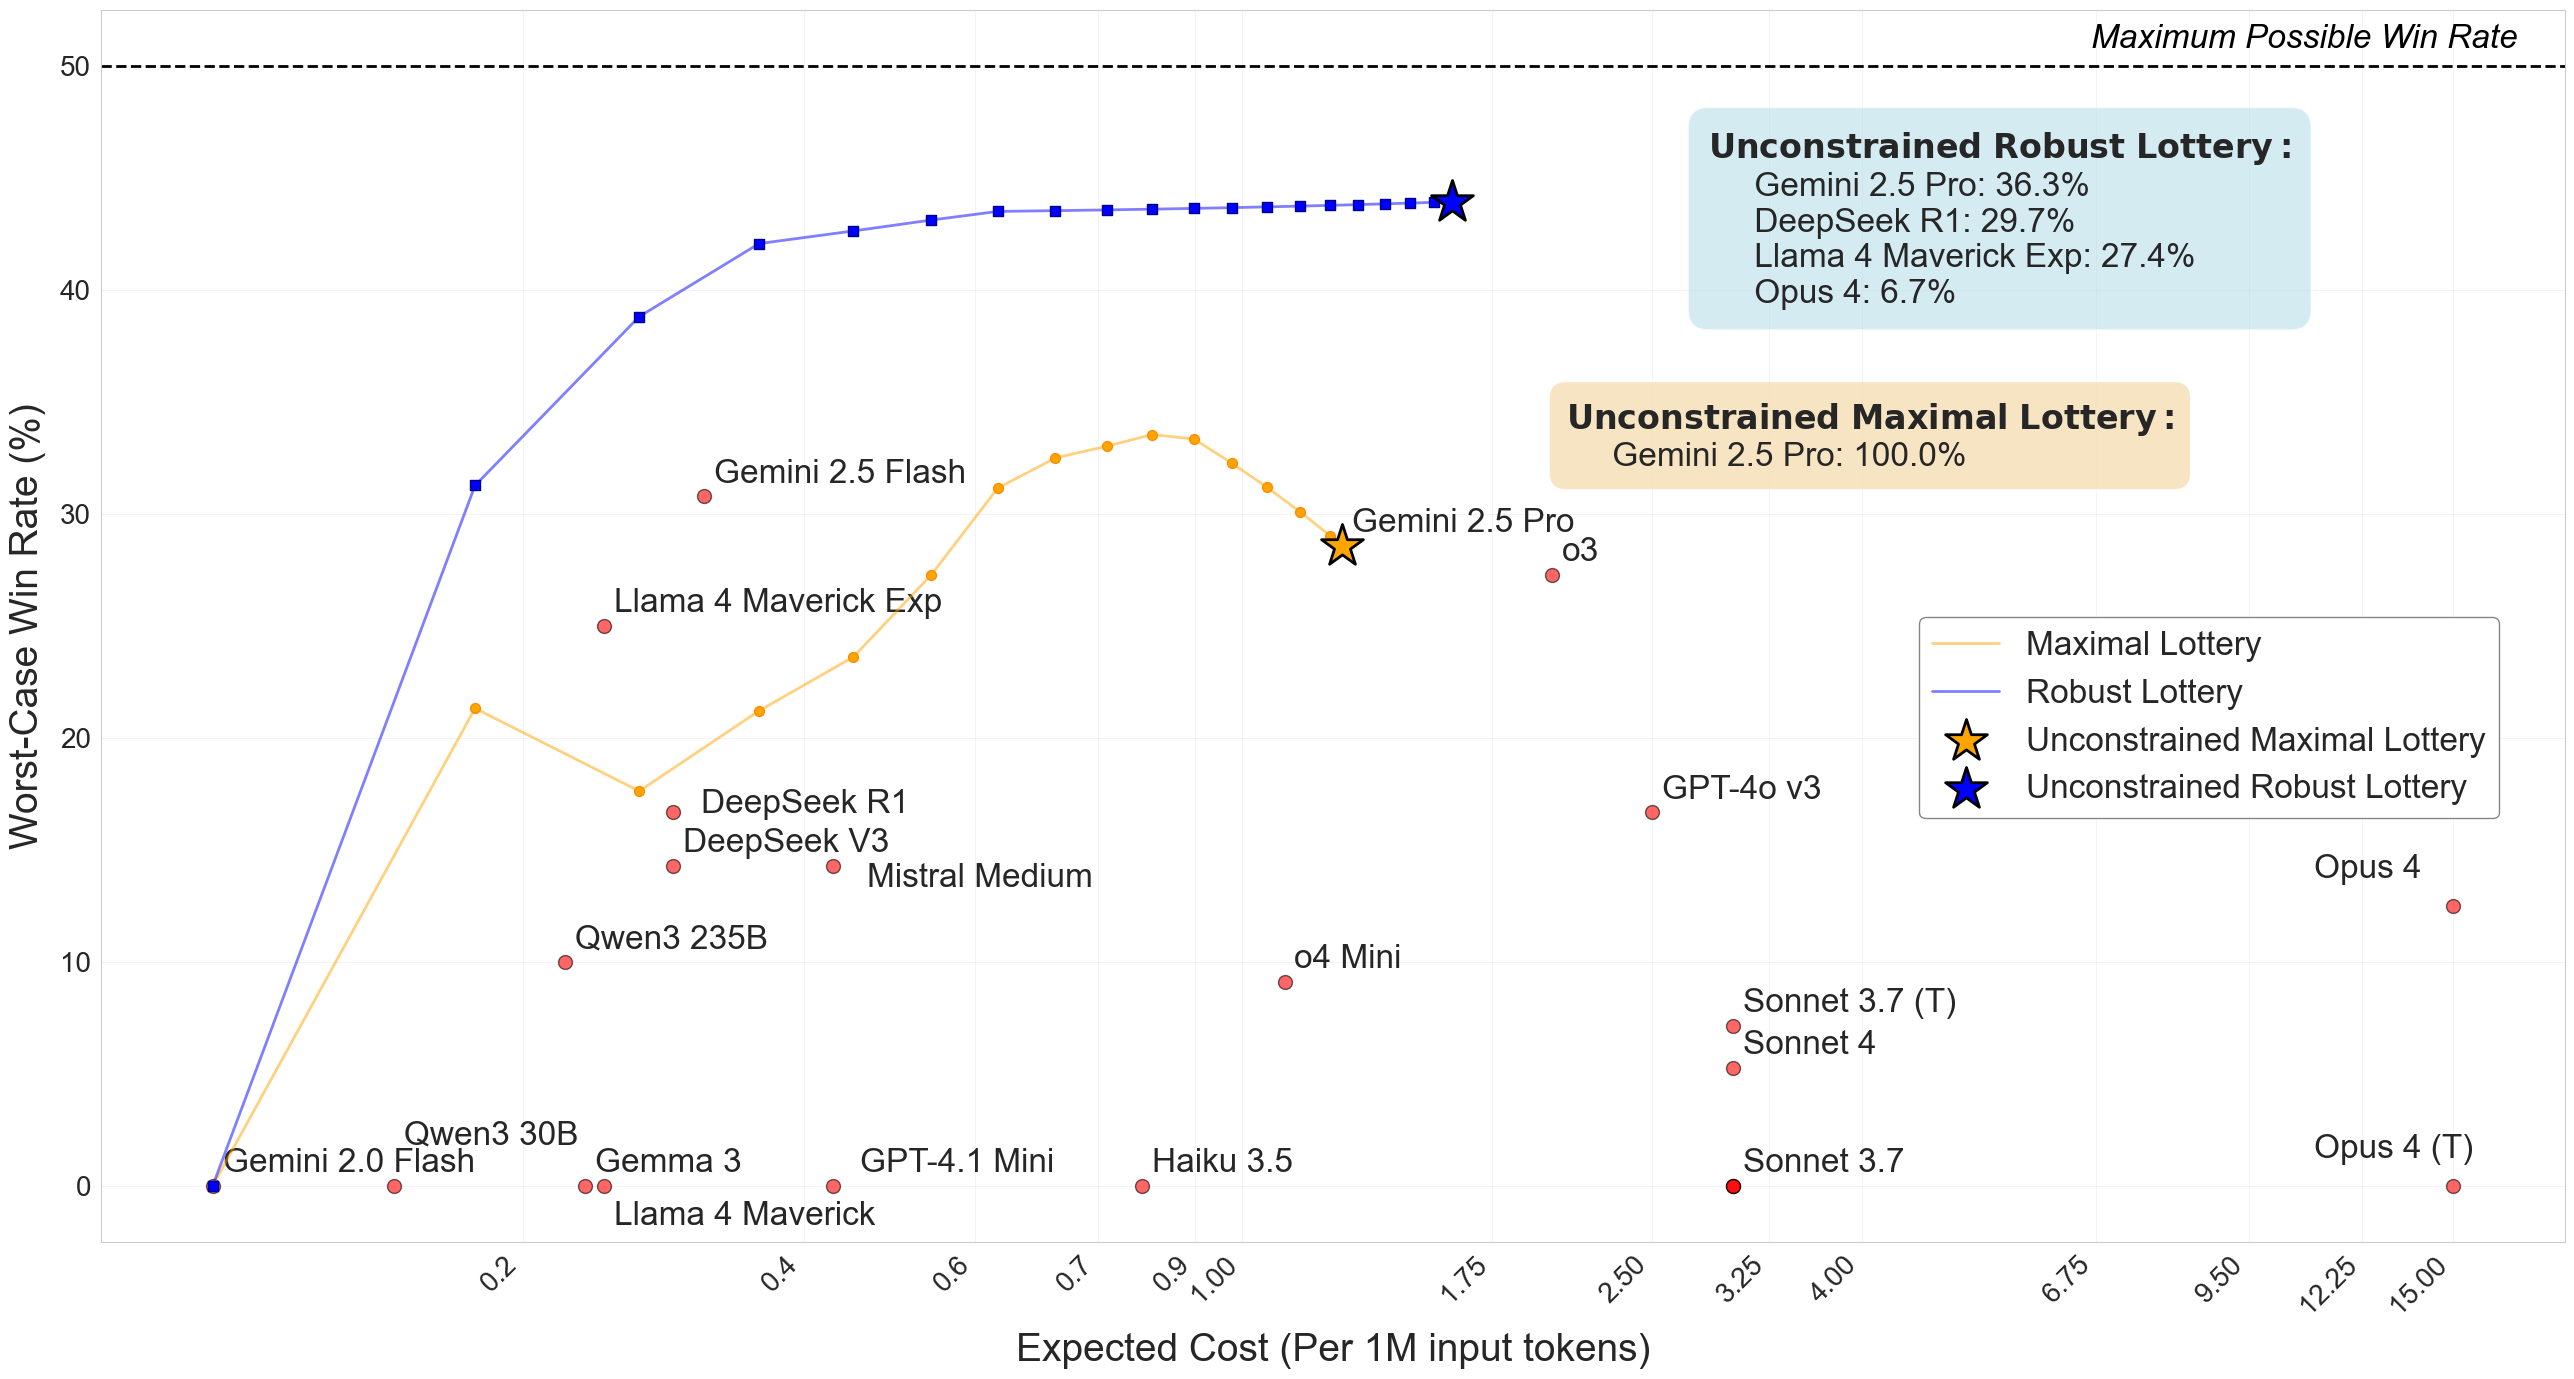

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(32, 16))
plt.subplots_adjust(right=0.85, left=0.08)
ax.scatter(clique_costs, model_worstcase_winrate, s=100, alpha=0.6, edgecolors='black', linewidths=1, color='red', label='_nolegend_', zorder=3)

# manual label placement to avoid overlap
texts = []
for i in range(len(clique_models)):
    if "claude-3-5-sonnet-20240620" in clique_models[i].lower() or "claude-3-5-sonnet-20241022" in clique_models[i].lower() or "claude-sonnet-4-20250514-thinking-32k" in clique_models[i].lower():
        continue
    
    if "claude-4-sonnet-20250307" in clique_models[i].lower():
        xytext_offset = (-20, 0)
    
    if "deepseek-r1" in clique_models[i].lower():
        xytext_offset = (20, 0)
    elif "claude-opus-4-20250514" in clique_models[i].lower():
        xytext_offset = (-100, 20)
    elif "gpt-4.1-mini-2025-04-14" in clique_models[i].lower():
        xytext_offset = (20, 10)
    elif "llama-4-maverick-17b-128e-instruct" in clique_models[i].lower():
        xytext_offset = (7, -28)  # Raise Llama Maverick label
    elif "qwen3-30b-a3b" in clique_models[i].lower():
        xytext_offset = (7, 30)  # Move Qwen3 30B label up
    elif "gemma-2-27b-it" in clique_models[i].lower():
        xytext_offset = (7, -20)
    elif "mistral-medium-2505" in clique_models[i].lower():
        xytext_offset = (25, -15)
    else:
        xytext_offset = (7, 10)
    
    text = ax.annotate(clique_models_simple[i],  (clique_costs[i], model_worstcase_winrate[i]),  xytext=xytext_offset,  textcoords='offset points', fontsize=24)
    texts.append(text)


if len(ml_budgeted_costs) > 0:
    ax.plot(ml_budgeted_costs, ml_budgeted_performances, '-', linewidth=2, color='orange', alpha=0.5, label='Maximal Lottery', zorder=4)
    ax.scatter(ml_budgeted_costs, ml_budgeted_performances, s=50, marker='o', color='orange', alpha=1.0, edgecolors='darkorange', linewidths=1, zorder=5)

if len(robust_budgeted_costs) > 0:
    ax.plot(robust_budgeted_costs, robust_budgeted_performances, '-', linewidth=2, color='blue', alpha=0.5, label='Robust Lottery', zorder=4)
    ax.scatter(robust_budgeted_costs, robust_budgeted_performances, s=50, marker='s', color='blue', alpha=1.0, edgecolors='darkblue', linewidths=1, zorder=5)

ax.scatter([ml_cost], [ml_worstcase_winrate], marker='*', s=1000, edgecolors='black', linewidths=2, color='orange', zorder=6, label='Unconstrained Maximal Lottery')
# ax.annotate("ML", (ml_cost, ml_worstcase_winrate), xytext=(30, 30), textcoords='offset points', fontsize=24, fontweight='bold')

ml_indices = np.where(p_ml > 1e-6)[0]
ml_indices_sorted = ml_indices[np.argsort(p_ml[ml_indices])[::-1]]
ml_models_str = r"$\mathbf{Unconstrained\ Maximal\ Lottery:}$" + "\n     "
for i in ml_indices_sorted:
    percentage = f"{100 * p_ml[i]:.1f}%"
    ml_models_str += f"{clique_models_simple[i]}: {percentage:>1s}\n     "
ml_models_str = ml_models_str.rstrip()

ax.scatter([robust_cost], [robust_winrate], marker='*', s=1000, edgecolors='black', linewidths=2, color='blue', zorder=6, label='Unconstrained Robust Lottery')
# ax.annotate("Robust ML", (robust_cost, robust_winrate), xytext=(10, 10), textcoords='offset points', fontsize=24, fontweight='bold')

robust_indices = np.where(p_robust > 1e-6)[0]
robust_indices_sorted = robust_indices[np.argsort(p_robust[robust_indices])[::-1]]
robust_models_str = r"$\mathbf{Unconstrained\ Robust\ Lottery:}$" + "\n     "
for i in robust_indices_sorted:
    percentage = f"{100 * p_robust[i]:.1f}%"
    robust_models_str += f"{clique_models_simple[i]}: {percentage:>1s}\n     "
robust_models_str = robust_models_str.rstrip()

ax.set_xscale('log')
ticks_0 = np.linspace(0.2, 0.9, 5) 
ticks_1 = np.linspace(1.0, 4.0, 5) 
ticks_2 = np.linspace(4.0, 15, 5)[1:]  
tick_values = np.concatenate([ticks_0, ticks_1, ticks_2])
tick_values = np.unique(tick_values)

tick_labels = []
for t in tick_values:
    if t < 1:
        tick_labels.append(f'{t:.1f}')
    else:
        tick_labels.append(f'{t:.2f}')

ax.set_xticks(tick_values)
ax.set_xticklabels(tick_labels, rotation=45, ha='right')
ax.set_xlabel('Expected Cost (Per 1M input tokens)', fontsize=28, labelpad=10)
ax.set_ylabel('Worst-Case Win Rate (%)', fontsize=28, labelpad=10)
ax.tick_params(labelsize=20)
ax.grid(True, alpha=0.3)

xlim = ax.get_xlim()
ax.axhline(y=50, color='black', linestyle='--', linewidth=2, zorder=2)
ax.text(xlim[1] * 0.9, 50.5, 'Maximum Possible Win Rate', fontsize=24, ha='right', va='bottom', color='black', fontstyle='italic')

ax.legend(loc='lower right', bbox_to_anchor=(0.98, 0.33), fontsize=24, labelspacing=0.5, framealpha=0.95, facecolor='white', edgecolor='gray')
ml_star_data = (ml_cost, ml_worstcase_winrate)
robust_star_data = (robust_cost, robust_winrate)

ml_star_display = ax.transData.transform(ml_star_data)
robust_star_display = ax.transData.transform(robust_star_data)
ml_star_fig = fig.transFigure.inverted().transform(ml_star_display)
robust_star_fig = fig.transFigure.inverted().transform(robust_star_display)

horizontal_padding = 0.07  
horizontal_padding_robust = 0.01
vertical_offset_ml = -0.01
vertical_offset_robust = -0.04

ml_box_x = ml_star_fig[0] + horizontal_padding
ml_box_y = ml_star_fig[1] + vertical_offset_ml
robust_box_x = robust_star_fig[0] + horizontal_padding + horizontal_padding_robust
robust_box_y = robust_star_fig[1] + vertical_offset_robust

fig.text(ml_box_x, ml_box_y, ml_models_str, fontsize=24, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8, pad=0.5), verticalalignment='bottom', horizontalalignment='left')
fig.text(robust_box_x, robust_box_y, robust_models_str, fontsize=24, bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.5, pad=0.6), verticalalignment='top', horizontalalignment='left')

plt.savefig(f"cost_performance_frontier.pdf", dpi=300, bbox_inches='tight')
plt.show()

/var/folders/9f/h4t6nv113ssb7rbq9k8gbhcm0000gn/T/ipykernel_26854/827028365.py:45: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 3)
/var/folders/9f/h4t6nv113ssb7rbq9k8gbhcm0000gn/T/ipykernel_26854/827028365.py:45: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(0, 3)


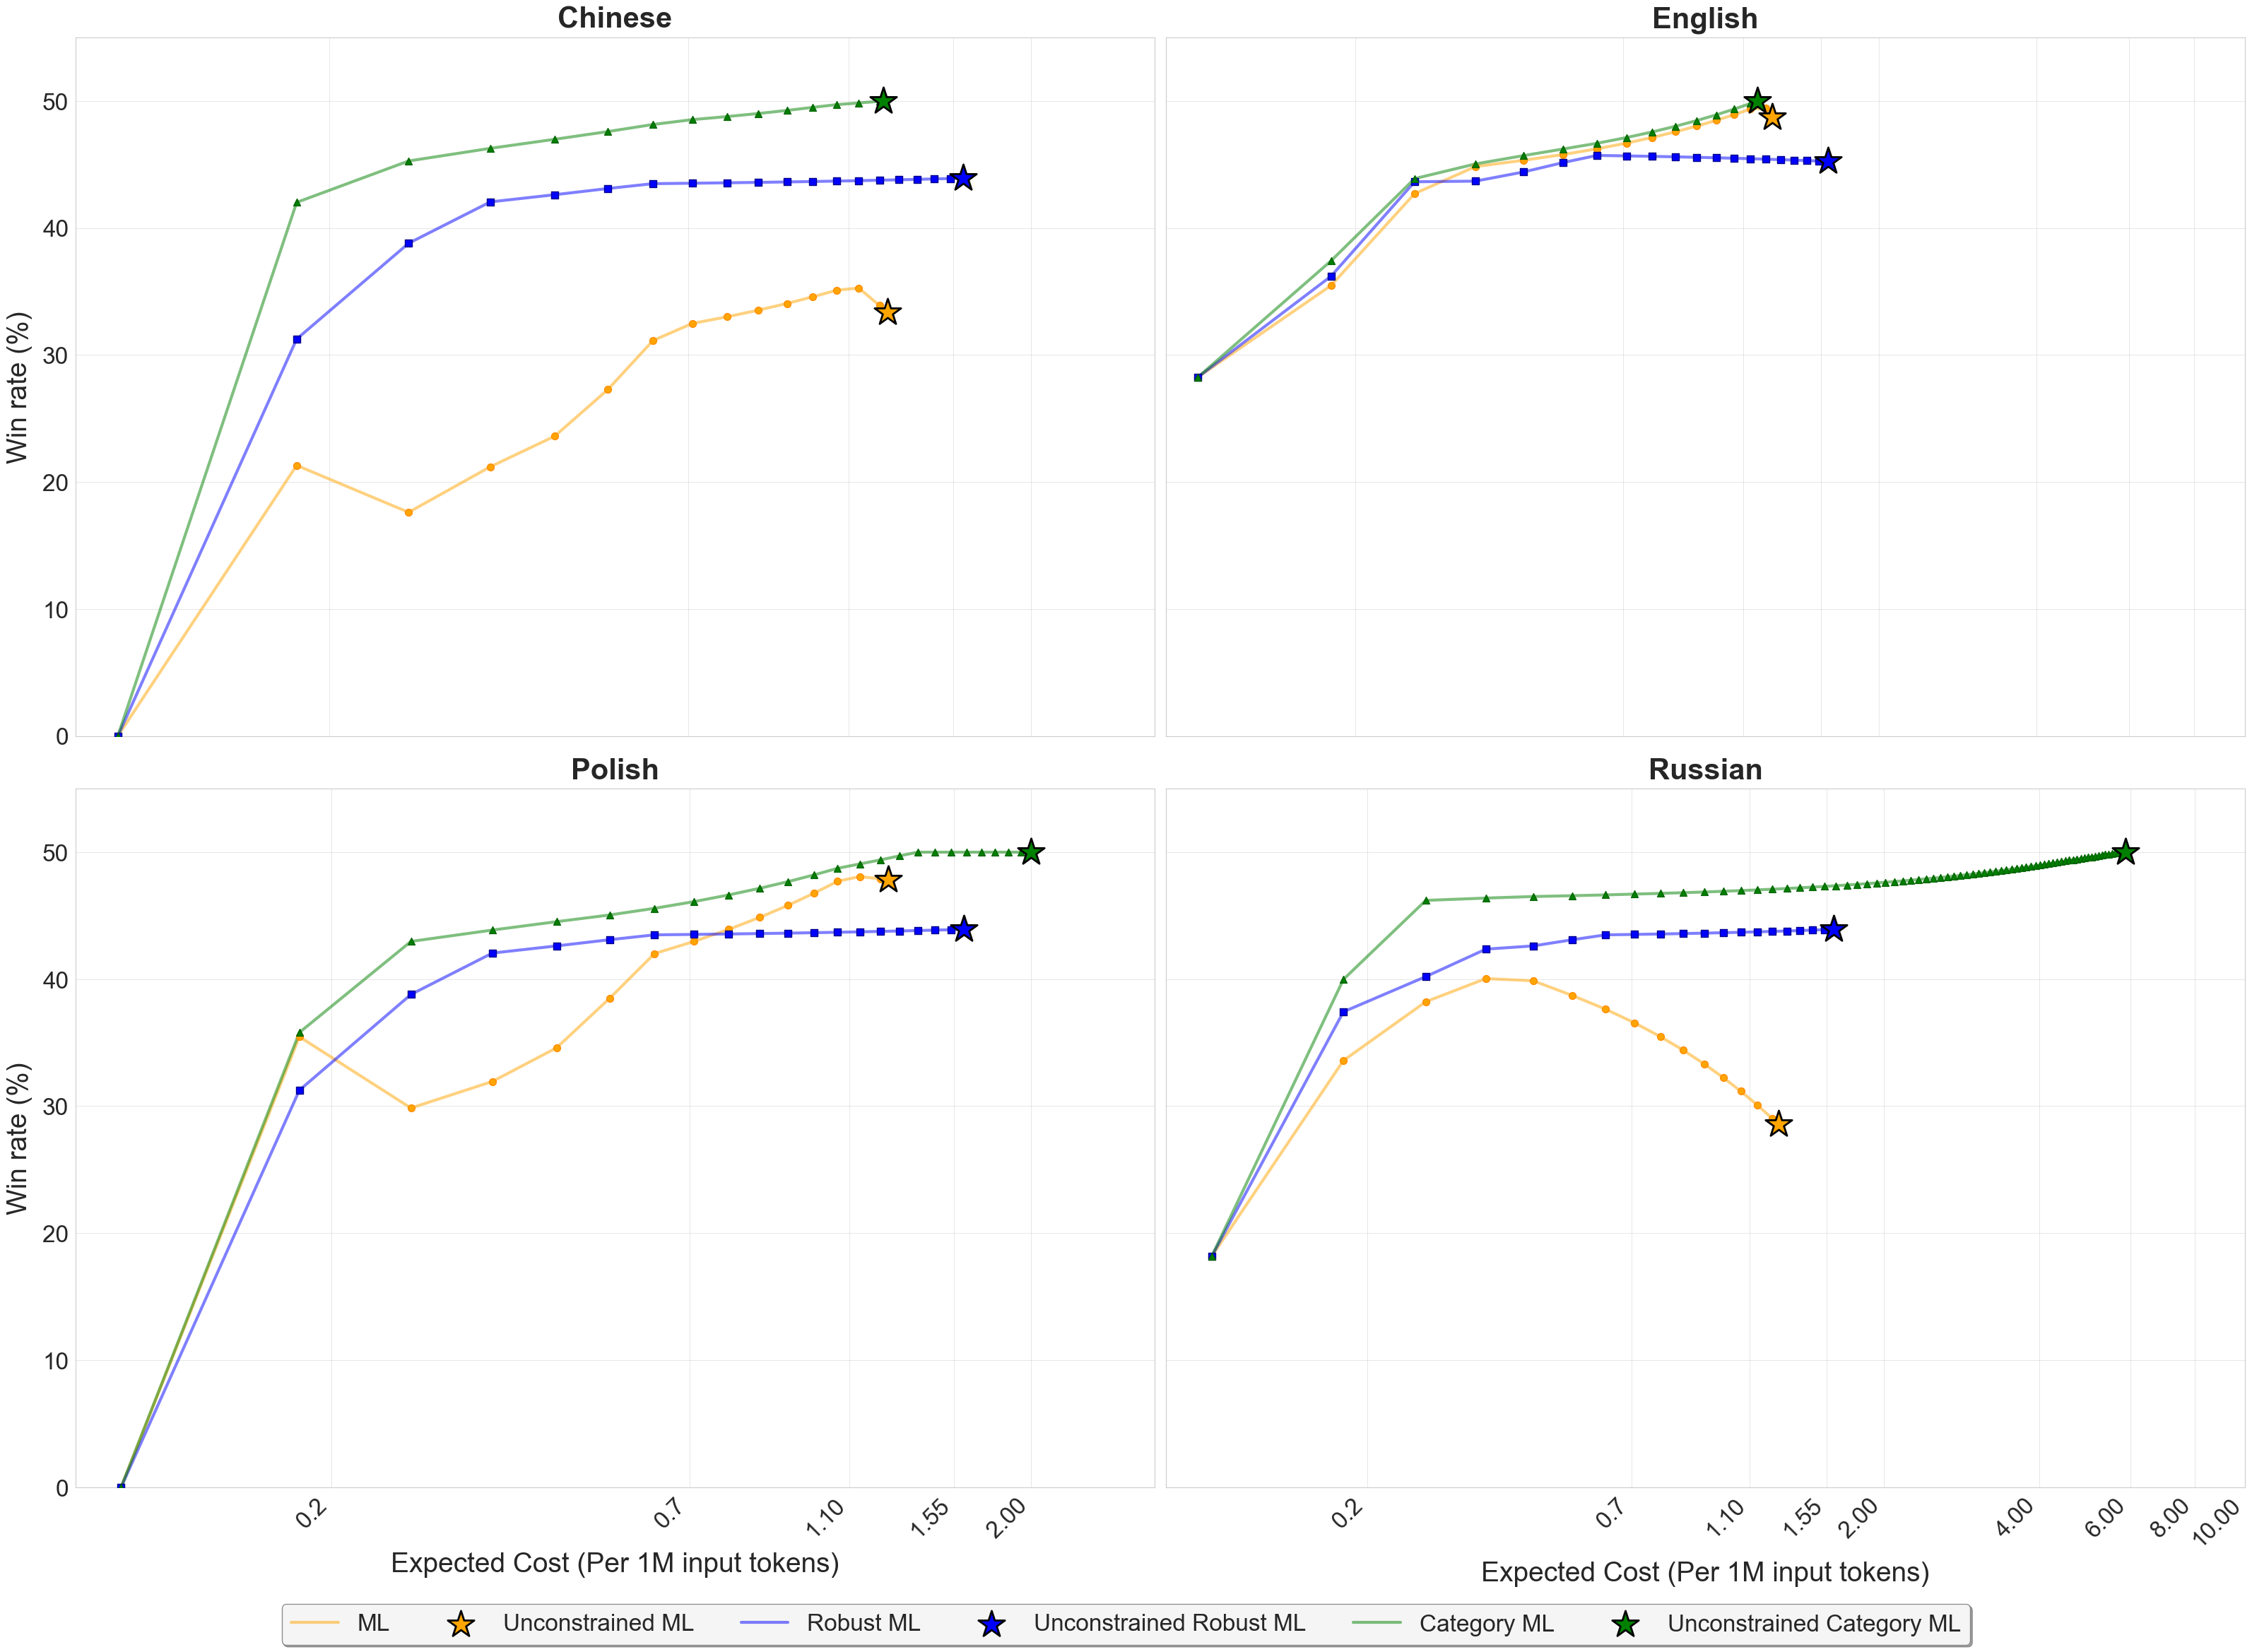

In [36]:
ml_worstcase_unconstrained_winrate = min([ml_per_cat_winrate[cat] for cat in all_categories])
robust_worstcase_unconstrained_winrate = min([robust_per_cat_winrate[cat] for cat in all_categories])

fig, axes = plt.subplots(2, 2, figsize=(32, 24))
axes = axes.flatten()

cats_to_plot = all_categories[:4]

ticks_0 = np.linspace(0.2, 2, 5)  
ticks_1 = np.linspace(2, 10, 5)
tick_values = np.concatenate([ticks_0, ticks_1])
tick_values = np.unique(tick_values)

tick_labels = []
for t in tick_values:
    if t < 1:
        tick_labels.append(f'{t:.1f}')
    else:
        tick_labels.append(f'{t:.2f}')

for idx, cat in enumerate(cats_to_plot):
    ax = axes[idx]
    if len(ml_budgeted_costs) > 0 and len(ml_budgeted_performances_per_cat[cat]) > 0:
        ax.plot(ml_budgeted_costs, ml_budgeted_performances_per_cat[cat], '-', linewidth=3, color='orange', alpha=0.5, label='ML', zorder=4)
        ax.scatter(ml_budgeted_costs, ml_budgeted_performances_per_cat[cat], s=50, marker='o', color='orange', alpha=1.0, edgecolors='darkorange', linewidths=1, zorder=5)

    if len(robust_budgeted_costs) > 0 and len(robust_budgeted_performances_per_cat[cat]) > 0:
        ax.plot(robust_budgeted_costs, robust_budgeted_performances_per_cat[cat], '-', linewidth=3, color='blue', alpha=0.5, label='Robust ML', zorder=4)
        ax.scatter(robust_budgeted_costs, robust_budgeted_performances_per_cat[cat], s=50, marker='s', color='blue', alpha=1.0, edgecolors='darkblue', linewidths=1, zorder=5)

    if len(category_ml_budgeted_costs[cat]) > 0 and len(category_ml_budgeted_performances[cat]) > 0:
        ax.plot(category_ml_budgeted_costs[cat], category_ml_budgeted_performances[cat], '-', linewidth=3, color='green', alpha=0.5, label='Category ML', zorder=4)
        ax.scatter(category_ml_budgeted_costs[cat], category_ml_budgeted_performances[cat], s=50, marker='^', color='green', alpha=1.0, edgecolors='darkgreen', linewidths=1, zorder=5)
    

    ax.scatter([category_ml_cost[cat]], [category_ml_per_cat_winrate[cat]], marker='*', s=800, edgecolors='black', linewidths=2, color='green', zorder=6, label='Unconstrained Category ML')
    ax.scatter([ml_cost], [ml_per_cat_winrate[cat]], marker='*', s=800, edgecolors='black', linewidths=2, color='orange', zorder=6, label='Unconstrained ML')
    ax.scatter([robust_cost], [robust_per_cat_winrate[cat]], marker='*', s=800, edgecolors='black', linewidths=2, color='blue', zorder=6, label='Unconstrained Robust ML')

    ax.set_xscale('log')
    ax.set_xticks(tick_values)
    ax.set_xticklabels(tick_labels, rotation=45, ha='right')
    
    if idx % 2 == 0:
        ax.set_xlim(0, 3)
    
    if idx >= 2:
        ax.set_xlabel('Expected Cost (Per 1M input tokens)', fontsize=28, labelpad=10)
    else:
        ax.set_xticklabels([])
    
    if idx % 2 == 0:
        ax.set_ylabel(f'Win rate (%)', fontsize=28, labelpad=10)
    else:
        ax.set_yticklabels([])
    
    ax.tick_params(labelsize=24)
    ax.grid(True, alpha=0.55, linewidth=0.6)
    ax.set_ylim(0, 55)
    ax.set_title(cat, fontsize=30, fontweight='bold', pad=10)

handles, labels = axes[0].get_legend_handles_labels()
desired_order = ['ML', 'Unconstrained ML', 'Robust ML', 'Unconstrained Robust ML', 'Category ML', 'Unconstrained Category ML']


ordered_handles = []
ordered_labels = []
for desired_label in desired_order:
    for handle, label in zip(handles, labels):
        if label == desired_label:
            ordered_handles.append(handle)
            ordered_labels.append(label)
            break

fig.legend(ordered_handles, ordered_labels, loc='lower center', ncol=6, fontsize=24, framealpha=0.9, facecolor='white', edgecolor='gray', shadow=True, bbox_to_anchor=(0.5, 0.02))

plt.tight_layout()
plt.subplots_adjust(bottom=0.12) 
plt.savefig(f"frontier_per_category.pdf", dpi=300, bbox_inches='tight')
plt.show()